## QuickTest

    makedb laptime
    makedb gluonts
    train model
    evaluate model


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import random
import mxnet as mx
from mxnet import gluon
import pickle
import json
import copy
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from pathlib import Path
import configparser

from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.trainer import Trainer
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.model.predictor import Predictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.r_forecast import RForecastPredictor
from gluonts.dataset.util import to_pandas

from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.distribution.student_t import StudentTOutput
from gluonts.distribution.multivariate_gaussian import MultivariateGaussianOutput

from indycar.model.NaivePredictor import NaivePredictor
from indycar.model.deeparw import DeepARWeightEstimator

#import indycar.model.stint_simulator_shortterm_pitmodel as stint
import indycar.model.quicktest_simulator as stint

INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU


In [2]:
# make indy car completed_laps dataset
# car_number, completed_laps, rank, elapsed_time, rank_diff, elapsed_time_diff 
def make_cl_data(dataset):

    # pick up data with valid rank
    rankdata = dataset.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
    rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')

    # resort by car_number, lap
    uni_ds = rankdata.sort_values(by=['car_number', 'completed_laps', 'elapsed_time'], ascending=True)    
    #uni_ds = uni_ds.drop(["unique_id", "best_lap", "current_status", "track_status", "lap_status",
    #                  "laps_behind_leade","laps_behind_prec","overall_rank","pit_stop_count",
    #                  "last_pitted_lap","start_position","laps_led"], axis=1)
    
    uni_ds = uni_ds.drop(["unique_id", "best_lap", 
                      "laps_behind_leade","laps_behind_prec","overall_rank","pit_stop_count",
                      "last_pitted_lap","start_position","laps_led"], axis=1)
        
    carnumber = set(uni_ds['car_number'])
    print('cars:', carnumber)
    print('#cars=', len(carnumber))
   
    # faster solution , uni_ds already sorted by car_number and lap
    uni_ds['rank_diff'] = uni_ds['rank'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['rank_diff'][mask] = 0
    
    uni_ds['time_diff'] = uni_ds['elapsed_time'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['time_diff'][mask] = 0
    
    #df = uni_ds[['car_number','completed_laps','rank','elapsed_time','rank_diff','time_diff']]
    #df = uni_ds[['car_number','completed_laps','rank',
    #             'rank_diff','time_diff',"current_status", "track_status", "lap_status",'elapsed_time']]
    
    df = uni_ds[['car_number','completed_laps','time_diff','rank','track_status', 'lap_status','elapsed_time']]
    
    return df

def make_lapstatus_data(dataset):
    final_lap = max(dataset.completed_laps)
    total_laps = final_lap + 1

    # get records for the cars that finish the race
    completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values
    completed_car_count = len(completed_car_numbers)

    print('count of completed cars:', completed_car_count)
    print('completed cars:', completed_car_numbers)
    
    #pick up one of them
    onecar = dataset[dataset['car_number']==completed_car_numbers[0]]
    onecar = onecar.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')
    return onecar[['completed_laps','track_status']]

def load_data(event, year=0):
    #inputfile = '../data/final/C_'+ event +'-' + year + '-final.csv'
    if year>0:
        inputfile = '../data/final/C_'+ event +'-' + year + '.csv'
    else:
        inputfile = '../data/final/C_'+ event +'.csv'
    
    #outputprefix = year +'-' + event + '-'
    dataset = pd.read_csv(inputfile)
    #dataset.info(verbose=True)    
    
    final_lap = max(dataset.completed_laps)
    total_laps = final_lap + 1

    # get records for the cars that finish the race
    completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values
    completed_car_count = len(completed_car_numbers)

    print('count of completed cars:', completed_car_count)
    print('completed cars:', completed_car_numbers)

    #make a copy
    alldata = dataset.copy()
    dataset = dataset[dataset['car_number'].isin(completed_car_numbers)]
    rankdata = alldata.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
    rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')
    
    cldata = make_cl_data(dataset)
    flagdata = make_lapstatus_data(dataset)
    acldata = make_cl_data(alldata)

    return alldata, rankdata, acldata, flagdata

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def get_lap2nextpit(lap_status, maxlap=200):
    """
    input:
        lapstatus  ; array of 0/1 indicating pitstops for each lap, nan means incomplete race
        maxlap     ; the max lap number of the race
    output:
        lap2nextpit ; array of the lap gap to the next pit for each lap
    
    """
    
    #pitstops = np.where(lap_status==1)[0]
                    
    pitstops = list(np.where(lap_status==1)[0])
    #if not len(lap_status) < maxlap:
    nans, x= nan_helper(lap_status)
    nan_count = np.sum(nans)      
    if nan_count == 0:
        #complete cars
        # the last stint, to the end
        pitstops.append(maxlap)
    
    lap2nextpit = np.zeros_like(lap_status)
    lap2nextpit[:] = np.nan
    
    #guard
    if len(pitstops)==0:
        return lap2nextpit
    
    idx = 0
    for lap in range(len(lap_status)):
        if lap < pitstops[idx]:
            lap2nextpit[lap] = pitstops[idx] - lap
        else:
            idx += 1
            if idx < len(pitstops):
                lap2nextpit[lap] = pitstops[idx] - lap
            else:
                break
            
    return lap2nextpit

def get_lapdata(acldata):
    """
    input:
        acldata['car_number','completed_laps','time_diff','rank','track_status', 'lap_status','elapsed_time']
    
        timediff: [car_number, completed_laps] -> elapsed time diff to leader
    output:
        lapdata = acldata[['car_number','completed_laps',
                           'time_diff','rank','track_status', 'lap_status','time_behind']].to_numpy()
    """
    COL_COMPLETED_LAPS = 1
    COL_ELAPSED_TIME = 6
    
    maxlap = np.max(acldata['completed_laps'].values)
    #'car_number','completed_laps','time_diff','rank','track_status', 'lap_status','time_behind'
    time_behind = []
    
    for lap in range(1, maxlap+1):
        this_lap = acldata[acldata['completed_laps']==lap][
            ['car_number','completed_laps','time_diff','rank',
             'track_status', 'lap_status','elapsed_time']].values
        
        min_elapsed_time = np.nanmin(this_lap[:,COL_ELAPSED_TIME].astype(np.float))
        #print(f'lap:{lap}, min_elapsed_time:{min_elapsed_time}')
        
        for row in this_lap:
            car_number = int(row[0])
            time_diff = row[2]
            rank = row[3]
            track_status = row[4]
            lap_status = row[5]
            
            timebehind = float(row[COL_ELAPSED_TIME]) - min_elapsed_time
            #
            time_behind.append([car_number, lap, time_diff,rank,track_status, lap_status,
                                timebehind, float(row[COL_ELAPSED_TIME])])
    
    #return
    lapdata = np.array(time_behind)
    return lapdata



# features: laptime, rank, track_status, lap_status, timediff
LAPTIME = 0
RANK = 1
TRACK_STATUS = 2
LAP_STATUS = 3
TIME_BEHIND = 4
CAUTION_LAPS_INSTINT = 5 
LAPS_INSTINT = 6
ELAPSED_TIME = 7
LAP2NEXTPIT = 8

_featureCnt = 9
        
def get_laptime_dataset(stagedata, inlap_status = 0):
    """
    #add caution_laps_instint, laps_instint
    
    input: (alldata, rankdata, acldata, flagdata)
    output: laptime & rank data
    
    [(
    eventid,
    carids : rowid -> carno,
    datalist: #car_number x features x #totallaps (padded by Nan)
        entry: [[laptime, rank, track_status, lap_status,
                caution_laps_instint, laps_instint]]
    )]
    """
    laptime_data = []
    for event in stagedata.keys():
        
        print(f'start event: {event}')
        
        laptime_rec = []
        eventid = events_id[event]
        
        alldata, rankdata, acldata, flagdata = stagedata[event]
        carlist = set(acldata['car_number'])
        laplist = set(acldata['completed_laps'])
        totalcars = len(carlist)
        totallaps = len(laplist)
        


        #carnumber -> carid
        carids={key:idx for idx, key in enumerate(carlist)}
        decode_carids={idx:key for idx, key in enumerate(carlist)}

        #init
        lap_instint = {carids[x]:0 for x in carlist}
        caution_instint = {carids[x]:0 for x in carlist}        
        
        #array: car_number x lap
        #laptime = np.zeros((totalcars, totallaps-1))
        #rank = np.zeros((totalcars, totallaps-1))
        laptime = np.empty((totalcars, totallaps-1))
        rank = np.empty((totalcars, totallaps-1))
        laptime[:] = np.NaN
        rank[:] = np.NaN
        

        datalist = np.empty((totalcars, _featureCnt, totallaps-1))
        datalist[:] = np.NaN
        
        #lapdata = acldata[['car_number','completed_laps',
        #                   'time_diff','rank','track_status', 'lap_status','elapsed_time']].to_numpy()
        
        #'car_number','completed_laps','time_diff','rank','track_status', 'lap_status','time_behind'
        lapdata = get_lapdata(acldata)
        
        
        for row in lapdata:
            #completed_laps
            if int(row[1]) == 0:
                continue
                
            #add to data array
            car_number = carids[int(row[0])]
            completed_laps = int(row[1])-1
            time_diff = float(row[2])
            rank = int(row[3])
            track_status = 1 if row[4]=='Y' else 0
            lap_status = 1 if row[5]=='P' else 0
            time_behind = float(row[6])
            
            datalist[car_number, LAPTIME, completed_laps] = time_diff
            datalist[car_number, RANK, completed_laps] = rank
            datalist[car_number, TRACK_STATUS, completed_laps] = track_status
            datalist[car_number, LAP_STATUS, completed_laps] = lap_status
            datalist[car_number, TIME_BEHIND, completed_laps] = time_behind

            datalist[car_number, ELAPSED_TIME, completed_laps] = float(row[7])

            
            #stint status
            if track_status == 1:
                caution_instint[car_number] += 1
            lap_instint[car_number] += 1
            if lap_status == 1:
                #new stint
                lap_instint[car_number] = 0
                caution_instint[car_number] = 0
                
                # add inlap feature into lap_Status
                # set the previous lap to inlap status
                
                # what does it mean?
                
                if (inlap_status!=0):
                    if inlap_status == 1:
                        # set the previous lap of 'P'
                        if completed_laps > 0:
                            #datalist[car_number, LAP_STATUS, completed_laps-1] = INLAP_STATUS
                            datalist[car_number, LAP_STATUS, completed_laps-1] = 1
                    else:
                        # set the next lap of 'P'
                        if completed_laps +1 < totallaps:
                            #datalist[car_number, LAP_STATUS, completed_laps-1] = INLAP_STATUS
                            datalist[car_number, LAP_STATUS, completed_laps + 1] = 1
                
            
            datalist[car_number, LAPS_INSTINT, completed_laps] = lap_instint[car_number]
            datalist[car_number, CAUTION_LAPS_INSTINT, completed_laps] = caution_instint[car_number]
                

                
        #update lap2nextpit in datalist
        for caridx in range(datalist.shape[0]):
            lap_status = datalist[caridx, LAP_STATUS, :]
            #pit status
            lap2nextpit = get_lap2nextpit(lap_status)
            datalist[caridx, LAP2NEXTPIT, :] = lap2nextpit        
                
        #add one record
        laptime_data.append([eventid, decode_carids, datalist])
        # push this event into stage dataframe
        print('event=%s, records=%s'%(event, datalist.shape))
        
    
    return laptime_data

In [3]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def test_flag(a, bitflag):
    return (a & bitflag) ==  bitflag

#
# remove NaN at the tail
# there should be no nans in the middle of the ts
COL_LAPTIME=0
COL_RANK=1
COL_TRACKSTATUS=2
COL_LAPSTATUS=3
COL_TIMEDIFF=4
COL_CAUTION_LAPS_INSTINT=5
COL_LAPS_INSTINT= 6
COL_ELAPSED_TIME= 7
COL_LAP2NEXTPIT = 8
#_featureCnt = 9

# added new features
COL_LEADER_PITCNT = 9
COL_TOTAL_PITCNT = 10
COL_SHIFT_TRACKSTATUS = 11
COL_SHIFT_LAPSTATUS = 12
COL_SHIFT_LEADER_PITCNT = 13
COL_SHIFT_TOTAL_PITCNT = 14

COL_LASTFEATURE = 14
# dynamically extended space in simulation
COL_TRACKSTATUS_SAVE = COL_LASTFEATURE+1
COL_LAPSTATUS_SAVE = COL_LASTFEATURE+2
COL_CAUTION_LAPS_INSTINT_SAVE = COL_LASTFEATURE+3
COL_LAPS_INSTINT_SAVE= COL_LASTFEATURE+4

COL_ENDPOS = COL_LASTFEATURE+5


FEATURE_STATUS = 2
FEATURE_PITAGE = 4
FEATURE_LEADER_PITCNT = 8
FEATURE_TOTAL_PITCNT = 16
FEATURE_SHIFT_TRACKSTATUS = 32
FEATURE_SHIFT_LAPSTATUS = 64
FEATURE_SHIFT_LEADER_PITCNT = 128
FEATURE_SHIFT_TOTAL_PITCNT  = 256

_feature2str= {
    FEATURE_STATUS : ("FEATURE_STATUS",'S'),
    FEATURE_PITAGE : ("FEATURE_PITAGE",'A'),
    FEATURE_LEADER_PITCNT : ("FEATURE_LEADER_PITCNT",'L'),
    FEATURE_TOTAL_PITCNT : ("FEATURE_TOTAL_PITCNT",'T'),
    FEATURE_SHIFT_TRACKSTATUS : ("FEATURE_SHIFT_TRACKSTATUS",'Y'),
    FEATURE_SHIFT_LAPSTATUS : ("FEATURE_SHIFT_LAPSTATUS",'P'),
    FEATURE_SHIFT_LEADER_PITCNT : ("FEATURE_SHIFT_LEADER_PITCNT",'L'),
    FEATURE_SHIFT_TOTAL_PITCNT  : ("FEATURE_SHIFT_TOTAL_PITCNT",'T')
    }


MODE_ORACLE = 0
MODE_NOLAP = 1
MODE_NOTRACK = 2
MODE_TESTZERO = 4
MODE_TESTCURTRACK = 8
#MODE_STR={MODE_ORACLE:'oracle', MODE_NOLAP:'nolap',MODE_NOTRACK:'notrack',MODE_TEST:'test'}

#_feature_mode = FEATURE_STATUS
def decode_feature_mode(feature_mode):
    
    retstr = []
    short_ret = []
    for feature in _feature2str.keys():
        if test_flag(feature_mode, feature):
            retstr.append(_feature2str[feature][0])
            short_ret.append(_feature2str[feature][1])
        else:
            short_ret.append('0')

    print(' '.join(retstr))
    
    return ''.join(short_ret)


def add_leader_cnt(selmat, rank_col=COL_RANK, pit_col=COL_LAPSTATUS, shift_len = 0, 
                   dest_col = COL_LEADER_PITCNT,
                   verbose = False):
    """
    add a new feature into mat(car, feature, lap)
    
    shift rank status
    
    input:
        sel_mat : laptime_data array [car, feature, lap]
    
    """
    dim1, dim2, dim3 = selmat.shape
    
    # rerank by the rank_col
    idx = np.argsort(selmat[:, rank_col,:], axis=0)
    true_rank = np.argsort(idx, axis=0).astype(np.float)

    # get leaderCnt by sorted pits
    pits = np.zeros((dim1,dim3))
    
    for lap in range(shift_len, dim3):
        col = idx[:, lap-shift_len]
        pits[:, lap] = selmat[col, pit_col, lap]
    
    leaderCnt = np.nancumsum(pits, axis=0) - pits
    
    if verbose:
        print('pits:\n')
        print(pits[:,190:])
        print('leaderCnt raw:\n')
        print(leaderCnt[:,190:])
    
    #remove nans
    nanidx = np.isnan(leaderCnt)
    leaderCnt[nanidx] = 0
    
    if verbose:
        print('leaderCnt after remove nan:\n')
        print(leaderCnt[:,190:])
    
    if dest_col == -1:
        #create a new data
        newmat = np.zeros((dim1,dim2+1,dim3))
        dest_col = dim2
        newmat[:,:dim2,:] = selmat.copy()
    else:
        #update mode
        newmat = selmat
    
    for lap in range(dim3):
        col = idx[:, lap]
        newmat[col, dest_col, lap] = leaderCnt[:, lap]
        
    # sync length to COL_RANK
    for rec in newmat:
        nans, x= nan_helper(rec[rank_col,:])
        nan_count = np.sum(nans)
        if nan_count > 0:
            #todo, some invalid nan, remove them
            #rec[dim2, np.isnan(rec[dim2,:])] = 0
            rec[dest_col, -nan_count:] = np.nan
    
    return newmat

def add_allpit_cnt(selmat, rank_col=COL_RANK, pit_col=COL_LAPSTATUS, 
                   dest_col = COL_TOTAL_PITCNT,verbose = False):
    """
    add a new feature into mat(car, feature, lap)
    
    total pits in a lap
    
    input:
        sel_mat : laptime_data array [car, feature, lap]
    
    """
    dim1, dim2, dim3 = selmat.shape

    #calc totalCnt vector for 
    totalCnt = np.nansum(selmat[:, pit_col, :], axis=0).reshape((-1))
    
    if verbose:
        print('pits:\n')
        print(pits[:,190:])
        print('totalCnt raw:\n')
        print(totalCnt[190:])
    
    #remove nans
    nanidx = np.isnan(totalCnt)
    totalCnt[nanidx] = 0
    
    if verbose:
        print('totalCnt after remove nan:\n')
        print(totalCnt[190:])
    
    if dest_col == -1:
        #create a new data
        newmat = np.zeros((dim1,dim2+1,dim3))
        dest_col = dim2
        newmat[:,:dim2,:] = selmat.copy()
    else:
        #update mode
        newmat = selmat

    for car in range(dim1):
        newmat[car, dest_col, :] = totalCnt
        
    # sync length to COL_RANK
    for rec in newmat:
        nans, x= nan_helper(rec[rank_col,:])
        nan_count = np.sum(nans)
        if nan_count > 0:
            #todo, some invalid nan, remove them
            #rec[dim2, np.isnan(rec[dim2,:])] = 0
            rec[dest_col, -nan_count:] = np.nan
    
    return newmat

def add_shift_feature(selmat, rank_col=COL_RANK, shift_col=COL_LAPSTATUS, shift_len = 2, 
                      dest_col = -1,verbose = False):
    """
    add a new feature into mat(car, feature, lap)
    
    shift features left in a lap
    
    warning: these are oracle features, be careful not to let future rank positions leaking
    
    input:
        sel_mat : laptime_data array [car, feature, lap]
    
    """
    dim1, dim2, dim3 = selmat.shape

    if dest_col == -1:
        #create a new data
        newmat = np.zeros((dim1,dim2+1,dim3))
        dest_col = dim2
        newmat[:,:dim2,:] = selmat.copy()
    else:
        #update mode
        newmat = selmat
    
    for car in range(dim1):
        # set empty status by default
        newmat[car, dest_col, :] = np.nan
        
        # get valid laps
        rec = selmat[car]
        nans, x= nan_helper(rec[rank_col,:])
        nan_count = np.sum(nans)
        recnnz = rec[shift_col, ~np.isnan(rec[rank_col,:])]
        reclen = len(recnnz)

        #shift copy
        newmat[car, dest_col, :reclen] = 0
        #newmat[car, dim2, :-shift_len] = selmat[car, shift_col, shift_len:]
        newmat[car, dest_col, :reclen-shift_len] = recnnz[shift_len:]
        
    # sync length to COL_RANK
    #for rec in newmat:
    #    nans, x= nan_helper(rec[rank_col,:])
    #    nan_count = np.sum(nans)
    #    if nan_count > 0:
    #        #todo, some invalid nan, remove them
    #        #rec[dim2, np.isnan(rec[dim2,:])] = 0
    #        rec[dim2, -nan_count:] = np.nan
    
    return newmat


def prepare_laptimedata(prediction_length, freq, 
                       test_event = 'Indy500-2018',
                       train_ratio=0.8,
                       context_ratio = 0.,
                       shift_len = -1):
    """
    prepare the laptime data for training
    
    1. remove short ts
    2. rerank the tss
    3. create new features
    
    input: 
        laptime_data   ; global var
    output:
        data  ; new representation of laptime_data
    
    """
    _laptime_data = laptime_data.copy()
    
    test_eventid = events_id[test_event]
    run_ts = COL_RANK
    
    # check shift len
    if shift_len < 0:
        shift_len = prediction_length
    print('prepare_laptimedata shift len:', shift_len)
    
    #_data: eventid, carids, datalist[carnumbers, features, lapnumber]->[laptime, rank, track, lap]]
    new_data = []
    for _data in _laptime_data:
        #skip eid > test_eventid
        if _data[0] > test_eventid:
            print('skip this event:', events[_data[0]])
            break
        
        if events[_data[0]] == test_event:
            test_mode = True
        else:
            test_mode = False        
        
        #statistics on the ts length
        ts_len = [ _entry.shape[1] for _entry in _data[2]]
        train_len = int(np.max(ts_len) * train_ratio)
        if train_len == 0:
            #use global train_len
            train_len = _train_len if not test_mode else _test_train_len
        
        if context_ratio != 0.:
            # add this part to train set
            context_len = int(np.max(ts_len) * context_ratio)
        else:    
            context_len = prediction_length*2
        if context_len < 10:
            context_len = 10
        
        print(f'before ====event:{events[_data[0]]}, prediction_len={prediction_length},train_len={train_len}, max_len={np.max(ts_len)}, min_len={np.min(ts_len)},context_len={context_len}')

        #rerank due to short ts removed
        #if run_ts == COL_RANK and dorerank == True:
        if True:
            sel_rows = []
            
            # use to check the dimension of features
            input_feature_cnt = _data[2].shape[1]
            if input_feature_cnt < COL_LASTFEATURE + 1:
                print('create new features mode, feature_cnt:', input_feature_cnt)
            else:
                print('update features mode, feature_cnt:', input_feature_cnt)
            
            for rowid in range(_data[2].shape[0]):
                # rec[features, lapnumber] -> [laptime, rank, track_status, lap_status,timediff]]
                rec = _data[2][rowid].copy()
                #remove nan(only tails)
                nans, x= nan_helper(rec[run_ts,:])
                nan_count = np.sum(nans)             
                rec = rec[:, ~np.isnan(rec[run_ts,:])]
                
                totallen = rec.shape[1]
                if ( totallen < train_len + prediction_length):
                    print(f'rerank a short ts: carid={_data[1][rowid]}，len={totallen}')
                    continue 
                else:
                    sel_rows.append(rowid)
                    
            #get selected matrix
            sel_idx = np.array(sel_rows)
            selmat = _data[2][sel_idx]
            
            # check the format of _data
            #ipdb.set_trace()
            
            mask = np.isnan(selmat[:,COL_RANK,:])
            
            idx = np.argsort(selmat[:,COL_RANK,:], axis=0)
            true_rank = np.argsort(idx, axis=0).astype(np.float)
            true_rank[mask] = np.nan
            
            if test_mode:
                #
                # for historical code mismatch, simulation does not run rerank
                #
                _data[2][sel_idx,COL_RANK,:] = true_rank + 1
            else:
                _data[2][sel_idx,COL_RANK,:] = true_rank
            
            # update the carno dict
            new_carids = {}
            for rowid in range(len(sel_idx)):
                carid = sel_idx[rowid]
                carno = _data[1][carid]
                new_carids[rowid] = carno

                
            # add new features
            # add leaderPitCnt
            if _data[0]==0:
                verbose = True
            else:
                verbose = False
                

            dest_col = -1 if input_feature_cnt < COL_LASTFEATURE + 1 else COL_LEADER_PITCNT
            data2_intermediate = add_leader_cnt(_data[2][sel_idx], shift_len = shift_len, dest_col=dest_col, verbose = verbose)
            
            # add totalPit
            dest_col = -1 if input_feature_cnt < COL_LASTFEATURE + 1 else COL_TOTAL_PITCNT
            data2_intermediate = add_allpit_cnt(data2_intermediate, dest_col=dest_col)
            
            #
            # add shift features, a fixed order, see the MACROS 
            #COL_SHIFT_TRACKSTATUS = 11
            #COL_SHIFT_LAPSTATUS = 12
            #COL_SHIFT_LEADER_PITCNT = 13
            #COL_SHIFT_TOTAL_PITCNT = 14
            #
            dest_col = -1 if input_feature_cnt < COL_LASTFEATURE + 1 else COL_SHIFT_TRACKSTATUS
            data2_intermediate = add_shift_feature(data2_intermediate, dest_col=dest_col,
                                                   shift_col=COL_TRACKSTATUS, shift_len = shift_len)
            
            dest_col = -1 if input_feature_cnt < COL_LASTFEATURE + 1 else COL_SHIFT_LAPSTATUS
            data2_intermediate = add_shift_feature(data2_intermediate, dest_col=dest_col,
                                                   shift_col=COL_LAPSTATUS, shift_len = shift_len)
            
            dest_col = -1 if input_feature_cnt < COL_LASTFEATURE + 1 else COL_SHIFT_LEADER_PITCNT
            data2_intermediate = add_shift_feature(data2_intermediate, dest_col=dest_col,
                                                   shift_col=COL_LEADER_PITCNT, shift_len = shift_len)
            
            dest_col = -1 if input_feature_cnt < COL_LASTFEATURE + 1 else COL_SHIFT_TOTAL_PITCNT
            data2_intermediate = add_shift_feature(data2_intermediate, dest_col=dest_col,
                                                   shift_col=COL_TOTAL_PITCNT, shift_len = shift_len)
            
            # final
            data2_newfeature = data2_intermediate
            
        new_data.append([_data[0], new_carids, data2_newfeature])
        
    return new_data


def get_real_features(feature_mode, rec, endpos):
    """
    construct the real value feature vector from feature_mode

    legacy code:
        real_features = {
            FEATURE_STATUS:[rec[COL_TRACKSTATUS,:],rec[COL_LAPSTATUS,:]],
            FEATURE_PITAGE:[rec[COL_TRACKSTATUS,:],rec[COL_LAPSTATUS,:],rec[COL_LAPS_INSTINT,:]],
            FEATURE_LEADERPITCNT:[rec[COL_TRACKSTATUS,:],rec[COL_LAPSTATUS,:],rec[COL_LEADER_PITCNT,:]],
            FEATURE_TOTALPITCNT:[rec[COL_TRACKSTATUS,:],rec[COL_LAPSTATUS,:],rec[COL_TOTAL_PITCNT,:]]
        }    
    
        real_features[feature_mode]
        
        
        COL_LEADER_PITCNT = 9
        COL_TOTAL_PITCNT = 10
        COL_SHIFT_TRACKSTATUS = 11
        COL_SHIFT_LAPSTATUS = 12
        COL_SHIFT_LEADER_PITCNT = 13
        COL_SHIFT_TOTAL_PITCNT = 14


        FEATURE_STATUS = 2
        FEATURE_PITAGE = 4
        FEATURE_LEADER_PITCNT = 8
        FEATURE_TOTAL_PITCNT = 16
        FEATURE_SHIFT_TRACKSTATUS = 32
        FEATURE_SHIFT_LAPSTATUS = 64
        FEATURE_SHIFT_LEADER_PITCNT = 128
        FEATURE_SHIFT_TOTAL_PITCNT  = 256        
    
    """
    
    features = []
    
    #check endpos
    if endpos <=0 :
        endpos = rec.shape[1]
    
    if test_flag(feature_mode, FEATURE_STATUS):
        features.append(rec[COL_TRACKSTATUS,:endpos])
        features.append(rec[COL_LAPSTATUS,:endpos])
        
    if test_flag(feature_mode, FEATURE_PITAGE):
        features.append(rec[COL_LAPS_INSTINT,:endpos])
        
    if test_flag(feature_mode, FEATURE_LEADER_PITCNT):
        features.append(rec[COL_LEADER_PITCNT,:endpos])
        
    if test_flag(feature_mode, FEATURE_TOTAL_PITCNT):
        features.append(rec[COL_TOTAL_PITCNT,:endpos])    
        
    if test_flag(feature_mode, FEATURE_SHIFT_TRACKSTATUS):
        features.append(rec[COL_SHIFT_TRACKSTATUS,:endpos])    
        
    if test_flag(feature_mode, FEATURE_SHIFT_LAPSTATUS):
        features.append(rec[COL_SHIFT_LAPSTATUS,:endpos])    

    if test_flag(feature_mode, FEATURE_SHIFT_LEADER_PITCNT):
        features.append(rec[COL_SHIFT_LEADER_PITCNT,:endpos])    

    if test_flag(feature_mode, FEATURE_SHIFT_TOTAL_PITCNT):
        features.append(rec[COL_SHIFT_TOTAL_PITCNT,:endpos])    
        
        
    return features

def make_dataset_byevent(_laptime_data, prediction_length, freq, 
                       useeid = False,
                       run_ts=COL_LAPTIME, 
                       test_event = 'Indy500-2018',
                       use_global_dict = True,
                       oracle_mode = MODE_ORACLE,
                       half_moving_win = True,
                       train_ratio=0.8,
                       log_transform = False,
                       context_ratio = 0.,
                       dorerank = True,
                       test_cars = []  
                ):
    """
    split the ts to train and test part by the ratio
    
    oracle_mode: false to simulate prediction in real by 
        set the covariates of track and lap status as nan in the testset
            
    
    """    
    #global setting
    feature_mode = _feature_mode
    
    start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series

    train_set = []
    test_set = []
    
    
    totalTSCnt = 0
    totalTSLen = 0
    test_eventid = events_id[test_event]
    
    #_data: eventid, carids, datalist[carnumbers, features, lapnumber]->[laptime, rank, track, lap]]
    for _data in _laptime_data:
        _train = []
        _test = []
        
        if events[_data[0]] == test_event:
            test_mode = True
        else:
            test_mode = False
            
        #statistics on the ts length
        ts_len = [ _entry.shape[1] for _entry in _data[2]]
        train_len = int(np.max(ts_len) * train_ratio)
        if train_len == 0:
            #use global train_len
            train_len = _train_len if not test_mode else _test_train_len
        
        if context_ratio != 0.:
            # add this part to train set
            context_len = int(np.max(ts_len) * context_ratio)
        else:    
            context_len = prediction_length*2
        if context_len < 10:
            context_len = 10
        
        print(f'after ====event:{events[_data[0]]}, prediction_len={prediction_length},train_len={train_len}, max_len={np.max(ts_len)}, min_len={np.min(ts_len)},context_len={context_len}')

        # process for each ts
        for rowid in range(_data[2].shape[0]):
            # rec[features, lapnumber] -> [laptime, rank, track_status, lap_status,timediff]]
            rec = _data[2][rowid].copy()
            
            #remove nan(only tails)
            nans, x= nan_helper(rec[run_ts,:])
            nan_count = np.sum(nans)             
            rec = rec[:, ~np.isnan(rec[run_ts,:])]
            
            # remove short ts
            totallen = rec.shape[1]
            
            totalTSCnt += 1
            totalTSLen += totallen
            
            if ( totallen < train_len + prediction_length):
                print(f'a short ts: carid={_data[1][rowid]}，len={totallen}')
                continue                
            
            if use_global_dict:
                carno = _data[1][rowid]
                carid = global_carids[_data[1][rowid]]
            else:
                #simulation dataset, todo, fix the carids as decoder
                carno = rowid
                carid = rowid
                
            #check carno in test_cars, testmode only
            if len(test_cars)>0 and carno not in test_cars:
                continue
                
            if useeid:
                static_cat = [carid, _data[0]]    
            else:
                static_cat = [carid]    
                
            #first, get target a copy    
            # target can be COL_XXSTATUS
            target_val = rec[run_ts,:].copy().astype(np.float32)
            if log_transform:
                target_val = np.log(target_val + 1.0)
            
            # selection of features
            if test_flag(oracle_mode, MODE_NOTRACK):                
                rec[COL_TRACKSTATUS, :] = 0
            if test_flag(oracle_mode, MODE_NOLAP):                
                rec[COL_LAPSTATUS, :] = 0

            test_rec_cnt = 0
            if not test_mode:
                # all go to train set
                real_features = get_real_features(feature_mode, rec, -1)
                
                _train.append({'target': target_val, 
                            'start': start, 
                            'feat_static_cat': static_cat,
                            'feat_dynamic_real': real_features
                          })
                    
            else:
                # reset train_len
                if context_ratio != 0.:
                    # all go to train set
                    #add [0, context_len] to train set 
                    # all go to train set
                    _train.append({'target': target_val[:context_len],  
                                'start': start, 
                                'feat_static_cat': static_cat,
                                'feat_dynamic_real': get_real_features(feature_mode, rec, context_len)
                              })
                              
                # testset
                # multiple test ts(rolling window as half of the prediction_length)
                #step = -int(prediction_length/2) if half_moving_win else -prediction_length
                step = -1
                for endpos in range(totallen, context_len+prediction_length, 
                                    step):

                    track_rec = rec[COL_TRACKSTATUS, :endpos].copy()
                    lap_rec = rec[COL_LAPSTATUS, :endpos].copy()
                    pitage_rec = rec[COL_LAPS_INSTINT, :endpos].copy()

                    real_features = get_real_features(feature_mode, rec, endpos)
                    
                    _test.append({'target': rec[run_ts,:endpos].astype(np.float32), 
                            'start': start, 
                            'feat_static_cat': static_cat,
                            'feat_dynamic_real': real_features
                             })
                                 
                    test_rec_cnt += 1
            
            #check feature cnt
            featureCnt = len(real_features)
            
            #add one ts
            print(f'carno:{carno}, totallen:{totallen}, nancount:{nan_count}, test_reccnt:{test_rec_cnt},featureCnt:{featureCnt}')

        train_set.extend(_train)
        test_set.extend(_test)

    print(f'train len:{len(train_set)}, test len:{len(test_set)}, totsl TsCnt:{totalTSCnt}, total ts len:{totalTSLen}')
    
    train_ds = ListDataset(train_set, freq=freq)
    test_ds = ListDataset(test_set, freq=freq)    
    
    return train_ds, test_ds, train_set, test_set

In [4]:
def init_estimator(model, gpuid, epochs=100, batch_size = 32, 
        target_dim = 3, distr_output = None, use_feat_static = True):
    
    if int(gpuid) < 0:
        ctx = "cpu"
    else:
        ctx = "gpu(%s)"%gpuid

    if model == 'deepAR':
        estimator = DeepAREstimator(
            prediction_length=prediction_length,
            context_length= context_length,
            use_feat_static_cat=True,
            cardinality=cardinality,
            distr_output = distr_output,
            freq=freq,
            trainer=Trainer(ctx=ctx, 
                            batch_size = batch_size,
                            epochs=epochs, 
                            learning_rate=1e-3, 
                            num_batches_per_epoch=100
                           )
        )
    elif model == 'deepARW':
        estimator = DeepARWEstimator(
            prediction_length=prediction_length,
            context_length= context_length,
            use_feat_static_cat=True,
            cardinality=cardinality,
            distr_output = distr_output,
            freq=freq,
            trainer=Trainer(ctx=ctx, 
                            batch_size = batch_size,
                            epochs=epochs, 
                            learning_rate=1e-3, 
                            num_batches_per_epoch=100
                           )
        )
        
    elif model == 'deepAR-Oracle':

        if use_feat_static:
            estimator = DeepAREstimator(
                prediction_length=prediction_length,
                context_length= context_length,
                use_feat_static_cat=use_feat_static,
                cardinality=cardinality,
                use_feat_dynamic_real=True,
                distr_output = distr_output,
                freq=freq,
                trainer=Trainer(ctx=ctx, 
                                batch_size = batch_size,
                                epochs=epochs, 
                                learning_rate=1e-3, 
                                num_batches_per_epoch=100
                               )
                )
        else:
            estimator = DeepAREstimator(
                prediction_length=prediction_length,
                context_length= context_length,
                use_feat_static_cat=use_feat_static,
                #cardinality=cardinality,
                use_feat_dynamic_real=True,
                distr_output = distr_output,
                freq=freq,
                trainer=Trainer(ctx=ctx, 
                                batch_size = batch_size,
                                epochs=epochs, 
                                learning_rate=1e-3, 
                                num_batches_per_epoch=100
                               )
                )
    elif model == 'deepARW-Oracle':

        if use_feat_static:
            estimator = DeepARWeightEstimator(
                prediction_length=prediction_length,
                context_length= context_length,
                use_feat_static_cat=use_feat_static,
                cardinality=cardinality,
                use_feat_dynamic_real=True,
                distr_output = distr_output,
                freq=freq,
                trainer=Trainer(ctx=ctx, 
                                batch_size = batch_size,
                                epochs=epochs, 
                                learning_rate=1e-3, 
                                #hybridize=False,
                                num_batches_per_epoch=100
                               )
                )
        else:
            estimator = DeepARWeightEstimator(
                prediction_length=prediction_length,
                context_length= context_length,
                use_feat_static_cat=use_feat_static,
                #cardinality=cardinality,
                use_feat_dynamic_real=True,
                distr_output = distr_output,
                freq=freq,
                trainer=Trainer(ctx=ctx, 
                                batch_size = batch_size,
                                epochs=epochs, 
                                learning_rate=1e-3, 
                                #hybridize=False,
                                num_batches_per_epoch=100
                               )
                )
            
    elif model == 'deepAR-nocarid':
        estimator = DeepAREstimator(
            prediction_length=prediction_length,
            context_length= context_length,
            use_feat_static_cat=use_feat_static,
            cardinality=cardinality,
            use_feat_dynamic_real=True,
            distr_output = distr_output,
            freq=freq,
            trainer=Trainer(ctx=ctx, 
                            batch_size = batch_size,
                            epochs=epochs, 
                            learning_rate=1e-3, 
                            num_batches_per_epoch=100
                           )
        )
    elif model == 'deepAR-multi':
        estimator = DeepAREstimator(
            prediction_length=prediction_length,
            context_length= context_length,
            use_feat_static_cat=use_feat_static,
            #cardinality=cardinality,
            use_feat_dynamic_real=True,
            freq=freq,
            trainer=Trainer(ctx=ctx, 
                            batch_size = batch_size,
                            epochs=epochs, 
                            learning_rate=1e-3, 
                            num_batches_per_epoch=100
                           ),
            distr_output=MultivariateGaussianOutput(dim=target_dim),
        )


    elif model == 'simpleFF':
        estimator = SimpleFeedForwardEstimator(
            num_hidden_dimensions=[10],
            prediction_length=prediction_length,
            context_length= context_length,
            freq=freq,
            trainer=Trainer(ctx=ctx, 
                            batch_size = batch_size,
                            epochs=epochs,
                            learning_rate=1e-3,
                            hybridize=False,
                            num_batches_per_epoch=100
                           )
        )
    elif model == 'deepFactor':
        estimator = DeepFactorEstimator(
            prediction_length=prediction_length,
            context_length= context_length,
            freq=freq,
            trainer=Trainer(ctx=ctx, 
                            batch_size = batch_size,
                            epochs=epochs, 
                            learning_rate=1e-3, 
                            num_batches_per_epoch=100
                           )
        )
    elif model == 'deepState':
        estimator = DeepStateEstimator(
            prediction_length=prediction_length,
            use_feat_static_cat=True,
            cardinality=cardinality,
            freq=freq,
            trainer=Trainer(ctx=ctx, 
                            batch_size = batch_size,
                            epochs=epochs, 
                            learning_rate=1e-3, 
                            num_batches_per_epoch=100
                           )
        )
    elif model == 'ets':
        estimator = RForecastPredictor(method_name='ets',freq= freq, prediction_length = prediction_length)
    elif model == 'prophet':

        estimator = ProphetPredictor(freq= freq, prediction_length = prediction_length)
    elif model == 'arima':
        estimator = RForecastPredictor(method_name='arima',freq= freq, prediction_length = prediction_length, trunc_length = 200)
    elif model == 'naive':
        estimator = NaivePredictor(freq= freq, prediction_length = prediction_length)
    else:
        logger.error('model %s not support yet, quit', model)
        sys.exit(-1)


    return estimator


In [5]:
#
# simulation engine general
#
def init_simulation(datasetid, testevent, taskid, runts, expid, predictionlen, 
               featuremode = stint.FEATURE_STATUS,
               pitmodel = 0, 
               inlapmode=0,
               train_len = 40,test_train_len=40):
    """
    input:
        prepared_laptimedata   ; global
    
    """
    
    
    #
    # configurataion
    #
    # model path:  <_dataset_id>/<_task_id>-<trainid>/
    #_dataset_id = 'indy2013-2018-nocarid'
    
    stint._inlap_status = inlapmode
    
    stint.init(pitmodel)
    
    # todo: add into stint code
    #here add new laptime_data with new features
    #
    stint.set_laptimedata(prepared_laptimedata)
    
    
    stint._dataset_id = datasetid
    stint._test_event = testevent
    #_test_event = 'Indy500-2019'

    stint._feature_mode = featuremode
    stint._context_ratio = 0.

    stint._task_id = taskid  # rank,laptime, the trained model's task
    stint._run_ts = runts   #COL_LAPTIME,COL_RANK
    stint._exp_id=expid  #rank, laptime, laptim2rank, timediff2rank... 

    stint._use_mean = True
    
    stint._train_len = train_len
    stint._test_train_len = test_train_len
    
    
def simulation(datasetid, testevent, taskid, runts, expid, predictionlen, 
               datamode, loopcnt, featuremode = stint.FEATURE_STATUS,
              pitmodel = 0, model = 'oracle', inlapmode=0, train_len = 40,test_train_len=40):
    """
    input:
        prepared_laptimedata   ; global
    
    """
    
    #
    # configurataion
    #
    # model path:  <_dataset_id>/<_task_id>-<trainid>/
    #_dataset_id = 'indy2013-2018-nocarid'
    
    stint._inlap_status = inlapmode
    
    stint.init(pitmodel)
    
    # todo: add into stint code
    #here add new laptime_data with new features
    #
    stint.set_laptimedata(prepared_laptimedata)
    #stint.set_laptimedata(laptime_data)
    
    stint._dataset_id = datasetid
    stint._test_event = testevent
    #_test_event = 'Indy500-2019'

    stint._feature_mode = featuremode
    stint._context_ratio = 0.

    stint._task_id = taskid  # rank,laptime, the trained model's task
    stint._run_ts = runts   #COL_LAPTIME,COL_RANK
    stint._exp_id=expid  #rank, laptime, laptim2rank, timediff2rank... 

    stint._use_mean = True
    
    stint._train_len = train_len
    stint._test_train_len = test_train_len
    
    predictor = stint.load_model(predictionlen, model,trainid='indy500',epochs = epochs, exproot='./')

    ret2 = {}
    for i in range(loopcnt):
        #df, full_samples, full_tss
        ret2[i] = stint.run_simulation_shortterm(predictor, predictionlen, stint.freq, datamode=datamode)

    acc = []
    for i in ret2.keys():
        df = ret2[i][0]
        _x = stint.get_evalret_shortterm(df)
        acc.append(_x)

    b = np.array(acc)
    print(np.mean(b, axis=0))
    
    #save keys
    #stint._pitmodel.save_keys('pitmodel-keys.pickle')
    
    return b, ret2

def long_predict(predictor, sampleCnt = 100):
    """
    use the farest samples only
    
    input:
        test_ds    ; global var
        predictor
    
    """
    
    def get_start(idx):
        td = forecasts[idx].start_date - start_time
        return td.days*24*60 + td.seconds//60
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=sampleCnt,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    start_time, row = next(tss[0].iterrows())

    first_start = get_start(-1)
    last_start = get_start(0)
    print(first_start, last_start)    
    
    import copy
    target = copy.deepcopy(forecasts[-1])

    #100, 10
    nsample, npredict = target.samples.shape
    print('sampel# x predictlen: ', nsample, npredict)
    
    newsamples = np.zeros((nsample, last_start - first_start + npredict))
    newsamples[:,:] = np.nan

    for idx in range(len(forecasts)):
        #copy samples
        start_pos = get_start(idx)

        pos = start_pos - first_start
        #copy sample to block
        #newsamples[:, pos:pos + npredict] = forecasts[idx].samples
        newsamples[:, pos + npredict - 1] = forecasts[idx].samples[:,-1]
        

    target.samples = newsamples

    #plot_prob_forecasts_ex([tss[0]],[target],output)
    
    return target, tss[0]



    


def get_alldf(dfx, year=2018):
    

    #dfx = ret[f'{model}-RANK-{year}-inlap-nopitage']
    #dfx = ret[f'{model}-TIMEDIFF-{year}-noinlap-nopitage']
    
    samples = dfx.keys()
    retdfs = []
    for id in samples:
        df = dfx[id][0]
        retdfs.append(df)
        
    if len(retdfs) > 1:
        dfout = pd.concat(retdfs)
    else:
        dfout = retdfs[0]
        
    return dfout
    
def get_alldf_mode(dfx, year=2018,mode=0):
    """
    mode: 
        0; mode
        1; mean
        2; median
    """
    dfall = get_alldf(dfx, year=year)
    
    cars = set(dfall.carno.values)
    startlaps = {}
    for car in cars:
        startlaps[car] = set(dfall[dfall['carno']==car].startlap.values)
        
    retdf = []
    for car in cars:
        for startlap in startlaps[car]:
            dfrec = dfall[(dfall['carno']==car) & (dfall['startlap']==startlap)]
            
            #get mode
            if mode == 0:
                pred_endrank = stats.mode(dfrec.pred_endrank.values).mode[0]
                #pred_endlap =  stats.mode(dfrec.pred_endlap.values).mode[0]
            elif mode == 1:
                #use mean
                pred_endrank = np.mean(dfrec.pred_endrank.values)
                #pred_endlap =  np.mean(dfrec.pred_endlap.values)
            elif mode == 2:
                #use mean
                pred_endrank = np.median(dfrec.pred_endrank.values)
                #pred_endlap =  np.median(dfrec.pred_endlap.values)
            
            firstrec = dfrec.to_numpy()[0,:]
            firstrec[6] = pred_endrank
            firstrec[7] = pred_endrank - firstrec[2]
            if firstrec[7] == 0:
                firstrec[8] = 0
            elif firstrec[7] > 0:
                firstrec[8] = 1
            else:
                firstrec[8] = -1
                
            #endlap, pred_endlap
            
        
            retdf.append(firstrec)
        
    #dfout = pd.concat(retdf)
    dfout = pd.DataFrame(retdf, columns =['carno', 'startlap', 'startrank',    
                                         'endrank', 'diff', 'sign',
                                         'pred_endrank', 'pred_diff', 'pred_sign',
                                         #'endlap','pred_endlap'
                                        ])
    print('df size:', len(dfout))
    return dfout

def get_allsamples(dfx, year=2018):
    
    runs = list(dfx.keys())
    runcnt = len(runs)
    
    full_samples = {}
    full_tss = dfx[runs[0]][2]
    carlist = list(full_tss.keys())
    samplecnt, lapcnt = dfx[runs[0]][1][carlist[0]].shape
    
    print('sacmplecnt:', samplecnt, 'lapcnt:',lapcnt,'runcnt:', runcnt)
    
    #empty samples
    for carid, carno in enumerate(carlist):
        full_samples[carno] = np.zeros((runcnt, lapcnt))
    
    for runid in runs:
        #one run
        tss = dfx[runid][2]
        forecast = dfx[runid][1]
        
        for carid, carno in enumerate(carlist):
            #get mean for this run
            forecast_mean = np.nanmean(forecast[carno], axis=0)
            full_samples[carno][runid, :] = forecast_mean
            
            #if carno==3 and runid == 0:
            #    print('forecast:',forecast_mean)
            
    return full_samples, full_tss

#straight implementation of prisk
def quantile_loss(target, quantile_forecast, q):
    return 2.0 * np.nansum(
        np.abs(
            (quantile_forecast - target)
            * ((target <= quantile_forecast) - q)
        )
    )

def abs_target_sum(target): 
    return np.nansum(np.abs(target)) 

def prisk(full_samples, full_tss, verbose = False):
    carlist = full_tss.keys()
    tss = []
    forecasts = []
    forecasts_mean = []
    freq = '1min'
    start = pd.Timestamp("01-01-2019", freq=freq) 

    for car in carlist:
        testcar = car
        fc = SampleForecast(samples = full_samples[testcar][:, 12:], freq=freq, start_date=start + 12)

        samples = np.mean(full_samples[testcar][:, 12:], axis =0, keepdims=True)
        fc_mean = SampleForecast(samples = samples, freq=freq, start_date=start + 12)

        index = pd.date_range(start='2019-01-01 00:00:00', freq = 'T', periods = len(full_tss[testcar]))
        ts = pd.DataFrame(index = index, data = full_tss[testcar])    

        tss.append(ts)
        forecasts.append(fc)
        forecasts_mean.append(fc_mean)

    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9]) 
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(tss))
    if verbose:
        print(json.dumps(agg_metrics, indent=4))  
    
    print(agg_metrics["wQuantileLoss[0.1]"], agg_metrics["wQuantileLoss[0.5]"],agg_metrics["wQuantileLoss[0.9]"])
    
    return agg_metrics


def prisk_direct_bysamples2(full_samples, full_tss, quantiles=[0.1,0.5,0.9], startid = 12, verbose=False):
    """
    target: endrank
    forecast: pred_endrank
    item_id: <carno, startlap>
    """
    
    carlist = full_tss.keys()
    
    prisk = np.zeros((len(carlist), len(quantiles)))
    target_sum = np.zeros((len(carlist)))
    aggrisk = np.zeros((len(quantiles)))
    
    for carid, carno in enumerate(carlist):

        # for this car
        forecast = full_samples[carno]
        target = full_tss[carno]
        
        #calc quantiles
        # len(quantiles) x 1
        quantile_forecasts = np.quantile(forecast, quantiles, axis=0)
        
        for idx, q in enumerate(quantiles):
            q_forecast = quantile_forecasts[idx]
            prisk[carid, idx] = quantile_loss(target[startid:], q_forecast[startid:], q)
            target_sum[carid] = abs_target_sum(target[startid:])
            
        if verbose==True and carno==3:
            print('target:', target[startid:])
            print('forecast:', q_forecast[startid:])
            print('target_sum:', target_sum[carid])
            
            print('quantile_forecasts:', quantile_forecasts[:,startid:])
        
    #agg
    #aggrisk = np.mean(prisk, axis=0)
    prisk_sum = np.nansum(prisk, axis=0)
    if verbose==True:
        print('prisk:',prisk)
        print('prisk_sum:',prisk_sum)
        print('target_sum:',target_sum)
    for idx, q in enumerate(quantiles):
        aggrisk[idx] = np.divide(prisk_sum[idx], np.sum(target_sum))
    
    agg_metrics = {}
    for idx, q in enumerate(quantiles):
        agg_metrics[f'wQuantileLoss[{q}]'] = aggrisk[idx]
        
    print(agg_metrics.values())
    
    return agg_metrics, aggrisk

In [6]:
def prisk_direct_bysamples(full_samples, full_tss, quantiles=[0.1,0.5,0.9], startid = 12, verbose=False):
    """
    calculate prisk by <samples, tss> directly (equal to gluonts implementation)
    
    target: endrank
    forecast: pred_endrank
    item_id: <carno, startlap>
    """
    
    carlist = full_tss.keys()
    
    prisk = np.zeros((len(carlist), len(quantiles)))
    target_sum = np.zeros((len(carlist)))
    aggrisk = np.zeros((len(quantiles)))
    
    for carid, carno in enumerate(carlist):

        # for this car
        forecast = full_samples[carno]
        target = full_tss[carno]
        
        #calc quantiles
        # len(quantiles) x 1
        quantile_forecasts = np.quantile(forecast, quantiles, axis=0)
        
        for idx, q in enumerate(quantiles):
            q_forecast = quantile_forecasts[idx]
            prisk[carid, idx] = quantile_loss(target[startid:], q_forecast[startid:], q)
            target_sum[carid] = abs_target_sum(target[startid:])
            
        if verbose==True and carno==3:
            print('target:', target[startid:])
            print('forecast:', q_forecast[startid:])
            print('target_sum:', target_sum[carid])
            
            print('quantile_forecasts:', quantile_forecasts[:,startid:])
        
    #agg
    #aggrisk = np.mean(prisk, axis=0)
    prisk_sum = np.nansum(prisk, axis=0)
    if verbose==True:
        print('prisk:',prisk)
        print('prisk_sum:',prisk_sum)
        print('target_sum:',target_sum)
    for idx, q in enumerate(quantiles):
        aggrisk[idx] = np.divide(prisk_sum[idx], np.sum(target_sum))
    
    agg_metrics = {}
    for idx, q in enumerate(quantiles):
        agg_metrics[f'wQuantileLoss[{q}]'] = aggrisk[idx]
        
    print(agg_metrics.values())
    
    return agg_metrics, aggrisk

def clear_samples(full_samples, full_tss, clearidx):
    """
    clear the laps in clearidx
    """
    import copy
    ret_samples = copy.deepcopy(full_samples)
    ret_tss = copy.deepcopy(full_tss)
    
    
    carlist = full_tss.keys()
    
    for carid, carno in enumerate(carlist):
        forecast = ret_samples[carno]
        target = ret_tss[carno]
        
        forecast[:, clearidx] = np.nan
        target[clearidx] = np.nan
        
        ret_samples[carno] = forecast
        ret_tss[carno] = target
        
    return ret_samples, ret_tss

def do_rerank(dfout, short=True):
    """
    carno','startlap','startrank','endrank','diff','sign','pred_endrank','pred_diff','pred_sign','endlap','pred_endlap
    
    output of prediction of target can be float
    
    resort the endrank globally
    
    """
    
    cols=['carno','startlap','startrank','endrank','diff','sign','pred_endrank','pred_diff','pred_sign','endlap','pred_endlap']
    colid={x:id for id,x in enumerate(cols)}
    
    #df = dfout.sort_values(by=['startlap','carno'])
    print('rerank...')
    laps = set(dfout.startlap.values)
    
    dfs = []
    for lap in laps:
        df = dfout[dfout['startlap']==lap].to_numpy()
        
        #print('in',df)
        
        idx = np.argsort(df[:,colid['pred_endrank']], axis=0)
        true_rank = np.argsort(idx, axis=0)
    
        df[:,colid['pred_endrank']] = true_rank
        
        #reset preds 
        df[:,colid['pred_diff']] = df[:,colid['pred_endrank']] - df[:,colid['endrank']]

        for rec in df:
            if rec[colid['pred_diff']] == 0:
                rec[colid['pred_sign']] = 0
            elif rec[colid['pred_diff']] > 0:
                rec[colid['pred_sign']] = 1
            else:
                rec[colid['pred_sign']] = -1        
        
        #print('out',df)
        if len(dfs) == 0:
            dfs = df
        else:
            dfs = np.vstack((dfs, df))
        #dfs.append(df)
        #np.vstack(df)
        
    #dfret = pd.concat(dfs)
    #data = np.array(dfs)
    if short:
        dfret = pd.DataFrame(dfs.astype(int), columns = cols[:-2])
    else:
        dfret = pd.DataFrame(dfs.astype(int), columns = cols)
    return dfret



In [7]:
def long_predict_bymloutput_multirun(output, dfin, sampleCnt=100):
    """
    input:
        test_ds
        predictor
    
    """
    def get_start(idx):
        td = forecasts[idx].start_date - start_time
        return td.days*24*60 + td.seconds//60
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=_predictor,  # predictor
        num_samples=sampleCnt,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    start_time, row = next(tss[0].iterrows())

    first_start = get_start(-1)
    last_start = get_start(0)
    print('first start:', first_start, 'last start:', last_start)    
    
    import copy
    target = copy.deepcopy(forecasts[-1])

    #100, 10
    nsample, npredict = target.samples.shape
    print('sampel# x predictlen: ', nsample, npredict)
    
    newsamples = np.zeros((nsample, last_start - first_start + npredict))
    newsamples[:,:] = np.nan
    
    for idx in range(len(forecasts)):
        #copy samples
        start_pos = get_start(idx)

        pos = start_pos - first_start + npredict - 1
        #copy sample to block
        #newsamples[:, pos:pos + npredict] = forecasts[idx].samples
        #newsamples[:, pos + npredict - 1] = forecasts[idx].samples[:,-1]
        
        # get prediction from ml output
        # pos = laps
        # 1 ... 10 | 11 <- start pos in forecasts
        # 0 ...  9 | 10 <- 9 is the startlap
        #
        startlap = start_pos  - 2
        #print('start pos:', start_pos, 'pos:',pos, 'startlap:', startlap)
        
        _rec = dfin[dfin['startlap']== startlap]
        if len(_rec) > 0:
            # rank start from 1 for visualization
            pred_val = _rec.pred_endrank.values
            
            #pred_val = _rec.pred_endrank.values
            #make sure shape match, 100 samples
            
            #newsamples[:, pos + npredict - 1] = pred_val + 1
            newsamples[:, pos] = pred_val + 1
            #print('startlap:', startlap, 'predrank:', pred_val)

    target.samples = newsamples
    
    print('multirun target samples:', target.samples.shape)

    #plot_prob_forecasts_ex([tss[0]],[target],output)
    
    return target,tss[0]

def long_predict_bymloutput(output, dfin):
    """
    input:
        test_ds
        predictor
    
    """
    def get_start(idx):
        td = forecasts[idx].start_date - start_time
        return td.days*24*60 + td.seconds//60
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=_predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    start_time, row = next(tss[0].iterrows())

    first_start = get_start(-1)
    last_start = get_start(0)
    print('first start:', first_start, 'last start:', last_start)    
    
    import copy
    target = copy.deepcopy(forecasts[-1])

    #100, 10
    nsample, npredict = target.samples.shape
    print('sampel# x predictlen: ', nsample, npredict)
    
    newsamples = np.zeros((nsample, last_start - first_start + npredict))
    newsamples[:,:] = np.nan
    
    for idx in range(len(forecasts)):
        #copy samples
        start_pos = get_start(idx)

        pos = start_pos - first_start + npredict - 1
        #copy sample to block
        #newsamples[:, pos:pos + npredict] = forecasts[idx].samples
        #newsamples[:, pos + npredict - 1] = forecasts[idx].samples[:,-1]
        
        # get prediction from ml output
        # pos = laps
        # 1 ... 10 | 11 <- start pos in forecasts
        # 0 ...  9 | 10 <- 9 is the startlap
        #
        startlap = start_pos  - 2
        #print('start pos:', start_pos, 'pos:',pos, 'startlap:', startlap)
        
        _rec = dfin[dfin['startlap']== startlap]
        if len(_rec) > 0:
            # rank start from 1 for visualization
            pred_val = _rec.pred_endrank.values[0]
            
            #pred_val = _rec.pred_endrank.values
            #make sure shape match, 100 samples
            
            #newsamples[:, pos + npredict - 1] = pred_val + 1
            newsamples[:, pos] = pred_val + 1
            #print('startlap:', startlap, 'predrank:', pred_val)

    target.samples = newsamples
    
    print('target samples:', target.samples.shape)

    #plot_prob_forecasts_ex([tss[0]],[target],output)
    
    return target,tss[0]

def long_predict_bysamples(output, samples, tss):
    """
    use the farest samples only
    
    input:
        samples
        tss
    
    """
    
    def get_start(idx):
        td = forecasts[idx].start_date - start_time
        return td.days*24*60 + td.seconds//60
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=_predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    start_time, row = next(tss[0].iterrows())

    first_start = get_start(-1)
    last_start = get_start(0)
    print(first_start, last_start)    
    
    import copy
    target = copy.deepcopy(forecasts[-1])

    #100, 10
    nsample, npredict = target.samples.shape
    print('sampel# x predictlen: ', nsample, npredict)
    
    #sample array size: last_start - first_start + npredict
    arraysize = last_start - first_start + npredict
    
    #error here
    #target.samples = samples[:,-len(forecasts)-1:] + 1
    #target.samples = samples[:, 10 + npredict:] + 1
    target.samples = samples[:, first_start:first_start + arraysize] + 1

    print('long_predict_bysamples==>target samples shape:', target.samples.shape)
    #plot_prob_forecasts_ex([tss[0]],[target],output)
    
    return target, tss[0]

#
# different idx format to bymloutput
#
def long_predict_bydf(output, dfin):
    """
    input:
        test_ds
        predictor
    
    """
    def get_start(idx):
        td = forecasts[idx].start_date - start_time
        return td.days*24*60 + td.seconds//60
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor= _predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    start_time, row = next(tss[0].iterrows())

    first_start = get_start(-1)
    last_start = get_start(0)
    print('first start:', first_start, 'last start:', last_start)    
    
    import copy
    target = copy.deepcopy(forecasts[-1])

    #100, 10
    nsample, npredict = target.samples.shape
    print('sampel# x predictlen: ', nsample, npredict)
    
    newsamples = np.zeros((nsample, last_start - first_start + npredict))
    newsamples[:,:] = np.nan
    
    for idx in range(len(forecasts)):
        #copy samples
        start_pos = get_start(idx)

        pos = start_pos - first_start + npredict - 1
        #copy sample to block
        #newsamples[:, pos:pos + npredict] = forecasts[idx].samples
        #newsamples[:, pos + npredict - 1] = forecasts[idx].samples[:,-1]
        
        # get prediction from ml output
        # pos = laps
        # 1 ... 10 | 11 <- start pos in forecasts
        # 0 ...  9 | 10 <- 9 is the startlap
        #
        startlap = start_pos  - 1
        #print('start pos:', start_pos, 'pos:',pos, 'startlap:', startlap)
        
        _rec = dfin[dfin['startlap']== startlap]
        if len(_rec) > 0:
            # rank start from 1 for visualization
            pred_val = _rec.pred_endrank.values[0]
            
            #pred_val = _rec.pred_endrank.values
            #make sure shape match, 100 samples
            
            #newsamples[:, pos + npredict - 1] = pred_val + 1
            newsamples[:, pos] = pred_val + 1
            #print('startlap:', startlap, 'predrank:', pred_val)

    target.samples = newsamples
    
    print('target samples:', target.samples.shape)

    #plot_prob_forecasts_ex([tss[0]],[target],output)
    
    return target,tss[0]

def get_ranknet_multirun(retdata, testcar, sampleCnt=100):
    dfs = []
    #for id in range(samplecnt):
    for id in retdata.keys():
        #ret['pitmodel-RANK-2018-inlap-nopitage']
        df = retdata[id][0]
        df = df[df['carno']==testcar]
        dfs.append(df)

    dfin_ranknet = pd.concat(dfs)

    print('dfin_ranknet size:', len(dfin_ranknet))
    
    #modify to fit to ml model format
    dfin_ranknet['startlap'] = dfin_ranknet['startlap'] - 1
    dfin_ranknet['startrank'] = dfin_ranknet['startrank'] - 1
    dfin_ranknet['endrank'] = dfin_ranknet['endrank'] - 1
                
    target_ranknet, tss_ranknet = long_predict_bymloutput_multirun('ranknet-rank', dfin_ranknet, sampleCnt=sampleCnt)                
                
    return target_ranknet, tss_ranknet

In [8]:
def ploth(ts_entry, forecast_entry, pits,caution, pitstop,outputfile,
                   colors = ['r','g','m'],
                   plabels= ['observed','svr','arima','ranknet'],
                   ylabel = 'RANK'):

    #plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    #plot_length = forecast_entry[0].samples.shape[1] + 10 
    
    #prediction_intervals = (50.0, 90.0)
    prediction_intervals = [90.0]
    
    #legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals]

    figcnt = len(forecast_entry)
    
    #fig, axs = plt.subplots(figcnt,1, figsize=(8,6))
    fig, axs = plt.subplots(1, figcnt, figsize=(12,3*figcnt))

    #colors = ['r','g','m']
    #plabels = ['observed','svr','arima','ranknet']
    
    for idx in range(figcnt):
        ax = plt.subplot(figcnt, 1, idx+1)
        #ax = plt.subplot(1, figcnt, idx+1)
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs[idx], linewidth=1)  # plot the time series
        #plot_length = int(forecast_entry[idx].samples.shape[1] *1.2) 
        ts_entry[idx].iloc[:,0].plot(linewidth=1, color='b',
                                            marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 


        # currank
        sv = ts_entry[idx].iloc[:,0].to_numpy()
        start = pd.Timestamp("01-01-2019", freq='1min') + 2
        date_index = pd.date_range(start, periods = len(sv)-2, freq='1min')
        df2 = pd.DataFrame(sv[:-2], index=date_index)        
        df2.iloc[:,0].plot(linewidth=0.5, color='k',
                                            marker='+', alpha=0.7, zorder=-1, label='CurRank') 
        
        
    #for idx in range(len(forecast_entry)):
    #    forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
    
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                             color=colors[idx],label=plabels[idx+1], zorder=10)
        #forecast_entry[1].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='b')
        #forecast_entry[2].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='r')
        
        #add mean line, compare with median
        #if forecast_entry[idx].samples.shape[0] > 1:
        if idx>3:
            mean_forecast = copy.deepcopy(forecast_entry[idx])
            mean_forecast.samples = np.mean(mean_forecast.samples, axis=0).reshape((1,-1))
            mean_forecast.copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                                 color='g',label='use-mean', zorder=10)
        
        
        if idx == figcnt-1:
            ax.set_xlabel('Lap')
        #if idx==0:
        ax.set_ylabel(ylabel)
        if idx==0:
            plt.title(outputfile)        
    
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 5)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x+1) for x in offset]
        plt.xticks(new_locs, new_labels)

        if figcnt==1 or idx < figcnt -1:
            print('xlim:', plt.xlim())
            xl, xr = plt.xlim()
            xlim_h = len(ts_entry[idx])
            
            #xlim_h = 100
            ax.set_xlim((xl+0,xl+xlim_h))
        elif idx == figcnt - 1:
            xlim_h = len(ts_entry[idx])
            
            #xlim_h = 100
            ax.set_xlim((xl+0,xl+xlim_h))
        
        if ylabel=='RANK':
            ax.set_ylim((-5,+40))
        else:
            ax.set_ylim((25,175))
            
        #ax.set_xlim((80,110))
        ax.set_zorder(-1)
        plt.grid(which="both", zorder=-1)
        ax.set_axisbelow(True)
        
        l=plt.legend(prop={'size': 10},loc='upper left')
        l.set_zorder(0.6)
        
        #add racestatus
        if ylabel=='RANK':
            ax.plot(xl+pits[:,0]-1,pits[:,1],'^',color='r', label='PitStop', linewidth=2,alpha=0.7, zorder=-1)
            add_status(ax,xl, caution, pitstop)
        else:
            ax.plot(xl+pits[:,0]-1,pits[:,2],'^',color='r', label='PitStop', linewidth=2,alpha=0.7, zorder=-1)
            add_status(ax,xl, caution, pitstop,y=27, height=3)
        
        
    
    plt.show()
    fig.tight_layout()
    fig.savefig(outputfile + '.pdf')    
    
def plotcar(carno):
    """
    input:
        alldata, rankdata; global data
    """
    #target_svr, target_rf,target_arima, target_oracle, target_ranknet_1run = savedata[carno]
    #target_oracle(by longpredict), tss_oracle_multirun,tss_ranknet_multirun
    tsss, targets = alldata[carno]
    
    pits, cautions, caution, pitstop,ranks,laptimes = get_racestatus(carno, rankdata)
    print(np.where(pitstop==1))
    
    ploth(tsss[:5], targets[:5], pits, caution, pitstop,
               'ranknet-rf-rank-forecast-%d'%carno,
                   colors = ['y','c','g','m','r'],
                   plabels= ['observed','SVR','RF','Arima','RrankNet-Oracle','RrankNet-MLP'])
    
def plotcar_laptime(carno):
    """
    input:
        alldata, rankdata; global data
    """
    #target_svr, target_rf,target_arima, target_oracle, target_ranknet_1run = savedata[carno]
    #target_oracle(by longpredict), tss_oracle_multirun,tss_ranknet_multirun
    tsss, targets = alldata[carno]
    
    pits, cautions, caution, pitstop,ranks,laptimes = get_racestatus(carno, rankdata)
    print(np.where(pitstop==1))
    
    ploth(tsss, targets, pits, caution, pitstop,
               'ranknet-oracle-laptime-forecast-%d'%carno,
                   colors = ['m','r'],
                   plabels= ['observed','RrankNet-Oracle','RrankNet-MLP'],
                ylabel='LapTime')
    
    
def plotrank(outputfile, mode='RANK' ):
    """
    input:
        alldata, rankdata; global data
    """
    
    figcnt = len(alldata)
    fig, axs = plt.subplots(1, figcnt, figsize=(12,3*figcnt))

    carlist = list(alldata.keys())
    
    for idx, carno in enumerate(carlist):
        #target_svr, target_rf,target_arima, target_oracle, target_ranknet_1run = savedata[carno]
        #target_oracle(by longpredict), tss_oracle_multirun,tss_ranknet_multirun
        tsss, targets = alldata[carno]

        pits, cautions, caution, pitstop,ranks,laptimes = get_racestatus(carno, rankdata)
        print(np.where(pitstop==1))
    
        ax = plt.subplot(figcnt, 1, idx+1)
        
        if mode == 'RANK':
            ax.plot(ranks, linewidth=1, color='b',marker='*', alpha=0.7, zorder=-1, label='Rank') 
            ax.set_ylim((-5,+35))
            ax.plot(pits[:,0]-1,pits[:,1],'^',color='r', label='PitStop', linewidth=2,alpha=0.7, zorder=-1)
            #add racestatus
            add_status(ax,0, caution, pitstop)

        else:
            ax.plot(laptimes, linewidth=1, color='b',marker='*', alpha=0.7, zorder=-1, label='LapTime') 
            ax.set_ylim((30,140))
            ax.plot(pits[:,0]-1,pits[:,2],'^',color='r', label='PitStop', linewidth=2,alpha=0.7, zorder=-1)
            #add racestatus
            add_status(ax,0, caution, pitstop,y=32, height=5)
        
        ax.set_xlim((0,200))
        
        ax.set_ylabel('car-%d'%carno)
        
        
    plt.show()
    fig.tight_layout()
    fig.savefig(outputfile + '.pdf')    
    
def plotcarx(carno):
    """
    input:
        alldata, rankdata; global data
    """
    #target_svr, target_rf,target_arima, target_oracle, target_ranknet_1run = savedata[carno]
    #target_oracle(by longpredict), tss_oracle_multirun,tss_ranknet_multirun
    tsss, targets = alldata[carno]
    
    oracle_tss, oracle_targets = oracledata[carno]
    
    tsss[2] = oracle_tss[1]
    targets[2] = oracle_targets[1]
    
    pits, cautions, caution, pitstop,ranks,laptimes = get_racestatus(carno, rankdata)
    print(np.where(pitstop==1))
    
    ploth(tsss[:5], targets[:5], pits, caution, pitstop,
               'ranknet-rf-rank-forecast-%d'%carno,
                   colors = ['y','c','g','m','r'],
                   plabels= ['observed','SVR','RF','Weighted-Oracle','RrankNet-Oracle','RrankNet-MLP'])
    
    
def plotoracle(alldata, carno, destdir):
    """
    input:
        alldata, rankdata; global data
    """
    
    outputfile = destdir + 'ranknet-oracle-forecast-%d'%carno
    
    #target_svr, target_rf,target_arima, target_oracle, target_ranknet_1run = savedata[carno]
    #target_oracle(by longpredict), tss_oracle_multirun,tss_ranknet_multirun
    tsss, targets = alldata[carno]
    
    pits, cautions, caution, pitstop,ranks,laptimes = get_racestatus(carno, rankdata)
    print(np.where(pitstop==1))
    
    ploth(tsss, targets, pits, caution, pitstop,
               outputfile,
               colors = ['y','c','g','m','r'],
               plabels= ['observed','1run-samples','1run-df','multimean','norerank-multimean','mrun-samples'])    
    

def plotallcars(alldata, outputfile, drawid = 0, 
               colors = ['g','c','m','r','y'],
               plabels= ['observed','1run-samples','1run-df','multimean','norerank-multimean','mrun-samples'],
               ylabel='RANK'):
    """
    plot a single fig for all cars
    
    input:
        prediction_length,freq   ; global var
        alldata, rankdata; global data
        drawid : long prediction result index in alldata[carno] to draw
    """
    figcnt = len(alldata)
    fig, axs = plt.subplots(1, figcnt, figsize=(12,3*figcnt))
    prediction_intervals = [90.0]
    #legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals]

    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 12,
        }    
    
    carlist = list(alldata.keys())
    
    for idx, carno in enumerate(carlist):
        #target_svr, target_rf,target_arima, target_oracle, target_ranknet_1run = savedata[carno]
        #target_oracle(by longpredict), tss_oracle_multirun,tss_ranknet_multirun
        ts_entry, forecast_entry = alldata[carno]

        pits, cautions, caution, pitstop,ranks,laptimes = get_racestatus(carno, rankdata)
        print(np.where(pitstop==1))
    
        ax = plt.subplot(figcnt, 1, idx+1)
    
        # observed
        ts_entry[drawid].iloc[:,0].plot(linewidth=1, color='b',
                                            marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 


        # currank
        sv = ts_entry[drawid].iloc[:,0].to_numpy()
        start = pd.Timestamp("01-01-2019", freq=freq) + prediction_length
        date_index = pd.date_range(start, periods = len(sv)-prediction_length, freq=freq)
        df2 = pd.DataFrame(sv[:-prediction_length], index=date_index)        
        df2.iloc[:,0].plot(linewidth=0.5, color='k',
                            marker='+', alpha=0.7, zorder=-1, label='CurRank') 
        
        #forecast
        forecast_entry[drawid].copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                             color=colors[drawid],label=plabels[drawid+1], zorder=10)
        
        if idx == figcnt-1:
            ax.set_xlabel('Lap')
        ax.set_ylabel(ylabel)
        
    
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 5)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x+1) for x in offset]
        plt.xticks(new_locs, new_labels)

        if figcnt==1 or idx < figcnt -1:
            print('xlim:', plt.xlim())
            xl, xr = plt.xlim()
            xlim_h = len(ts_entry[drawid])
            
            #xlim_h = 100
            ax.set_xlim((xl+0,xl+xlim_h))
        elif idx == figcnt - 1:
            xlim_h = len(ts_entry[drawid])
            
            #xlim_h = 100
            ax.set_xlim((xl+0,xl+xlim_h))
            
        #plt.title(outputfile)        
        plt.text(xl + xlim_h - 15, 35, f'car-{carno}',fontdict=font)
            
        
        if ylabel=='RANK':
            ax.set_ylim((-5,+40))
        else:
            ax.set_ylim((25,175))
            
        #ax.set_xlim((80,110))
        ax.set_zorder(-1)
        plt.grid(which="both", zorder=-1)
        ax.set_axisbelow(True)
        
        l=plt.legend(prop={'size': 10},loc='upper left')
        l.set_zorder(0.6)
        
        #add racestatus
        if ylabel=='RANK':
            ax.plot(xl+pits[:,0]-1,pits[:,1],'^',color='r', label='PitStop', linewidth=2,alpha=0.7, zorder=-1)
            add_status(ax,xl, caution, pitstop)
        else:
            ax.plot(xl+pits[:,0]-1,pits[:,2],'^',color='r', label='PitStop', linewidth=2,alpha=0.7, zorder=-1)
            add_status(ax,xl, caution, pitstop,y=27, height=3)
        
        
    
    plt.show()
    fig.tight_layout()
    fig.savefig(outputfile + '.pdf')      
    
    
def get_racestatus(carno, rankdata):
    df12 = rankdata[rankdata['car_number']==carno]
    #
    # completed_laps start from 0
    # in array mode completed_laps=1 should indexed by 0
    #
    data = df12[['completed_laps','rank','last_laptime','time_behind_leader']].values
    pitstop = df12[['lap_status']].values
    caution = df12[['track_status']].values
    pitstop = np.array([1 if x=='P' else 0 for x in pitstop])
    caution = np.array([1 if x=='Y' else 0 for x in caution])
    pitidx = np.where(pitstop == 1)
    pits = data[pitidx]
    yidx = np.where(caution == 1)
    cautions = data[yidx]
    
    ranks = df12[['rank']].values
    laptimes = df12[['last_laptime']].values

    #return pits, cautions, caution, pitstop
    return pits, cautions, caution[1:], pitstop[1:], ranks[1:],laptimes[1:]


#red = '#ff8080'
red = 'red'
#yellow = '#8080ff'
yellow = 'yellow'
#green = '#80ff80'
green = 'green'

def add_status(axs,xl, caution, pitstop, maxlap= 200, y=-4, height=2):
    """
    input:
        caution, pitstop : race status
    """
    maxlap = min(len(caution), len(pitstop))
    for lap in range(maxlap):
        fc = green
        if caution[lap] == 1:
            fc = yellow
        if pitstop[lap] == 1:
            fc = red
        ec = fc
        rectangle = plt.Rectangle((lap+xl-0.5,y), 1, height, fc=fc,ec=ec)
        #plt.gca().add_patch(rectangle)
        axs.add_patch(rectangle)    

In [9]:
def get_config():
    config = [
        _savedata,
        _skip_overwrite,
        _inlap_status,
        _feature_mode,
        _featureCnt,
        freq ,
        _train_len,
        prediction_length,
        context_ratio,
        context_length,
        contextlen,
        dataset,
        epochs,
        gpuid,
        _use_weighted_model,
        trainmodel,
        _use_cate_feature,
        use_feat_static,
        distroutput,
        batch_size,
        loopcnt,
        _test_event,
        testmodel,
        pitmodel,
        year
    ]
    
    return config

## run

In [10]:
WorkRootDir = 'QuickTestOutput'
#reference
#configname = 'weighted-noinlap-nopitage-nocate-c60-drank'
configname = 'weighted-noinlap-S0LTYPLT-nocate-c60-drank-pitmodel'
configfile = f'{configname}.ini'

if configfile != '':
    config = configparser.RawConfigParser()
    config.read(WorkRootDir + '/' + configfile)

    #set them back
    section = "RankNet-QuickTest"
    
    _savedata = config.getboolean(section, "_savedata")
    _skip_overwrite = config.getboolean(section, "_skip_overwrite")
    _inlap_status = config.getint(section, "_inlap_status") #0
    _feature_mode = config.getint(section, "_feature_mode") #FEATURE_STATUS
    _featureCnt = config.getint(section, "_featureCnt") #9
    freq = config.get(section, "freq") #"1min"
    _train_len = config.getint(section, "_train_len") #40
    prediction_length = config.getint(section, "prediction_length") #2
    context_ratio = config.getfloat(section, "context_ratio") #0.
    context_length =  config.getint(section, "context_length") #40
    
    dataset= config.get(section, "dataset") #'rank'
    epochs = config.getint(section, "epochs") #1000
    gpuid = config.getint(section, "gpuid") #5
    _use_weighted_model = config.getboolean(section, "_use_weighted_model")
    trainmodel = config.get(section, "trainmodel") #'deepARW-Oracle' if _use_weighted_model else 'deepAR-Oracle'
    
    _use_cate_feature = config.getboolean(section, "_use_cate_feature")
    
    distroutput = config.get(section, "distroutput") #'student'
    batch_size = config.getint(section, "batch_size") #32
    loopcnt = config.getint(section, "loopcnt") #2
    _test_event = config.get(section, "_test_event") #'Indy500-2018'
    testmodel = config.get(section, "testmodel") #'oracle'
    pitmodel = config.get(section, "pitmodel") #'oracle'
    year = config.get(section, "year") #'2018'
    
    contextlen = context_length
    use_feat_static = _use_cate_feature 

    #config1 = get_config()
    
else:
    print('Warning, please use config file')
    sys.exit(0)
    
    #
    # global settings
    #
    #_savedata = False
    _savedata = True
    _skip_overwrite = True

    #inlap status = 
    # 0 , no inlap
    # 1 , set previous lap
    # 2 , set the next lap
    _inlap_status = 0

    #
    # featuremode in [FEATURE_STATUS, FEATURE_PITAGE]:
    #
    _feature_mode = FEATURE_LEADERPITCNT
    _featureCnt = 9

    #
    # training parameters
    #
    freq = "1min"
    _train_len = 60
    prediction_length = 2

    context_ratio = 0.
    context_length =  60
    contextlen = context_length

    dataset='rank'
    epochs = 1000
    #epochs = 10
    gpuid = 5

    #'deepAR-Oracle','deepARW-Oracle'
    _use_weighted_model = True
    trainmodel = 'deepARW-Oracle' if _use_weighted_model else 'deepAR-Oracle'

    _use_cate_feature = False
    use_feat_static = _use_cate_feature 

    distroutput = 'student'
    batch_size = 32


    #
    # test parameters
    #
    loopcnt = 2
    _test_event = 'Indy500-2018'
    testmodel = 'oracle'
    pitmodel = 'oracle'
    year = '2018'
    
    #config2 = get_config()

In [11]:
# new added parameters
_test_train_len = 40
#loopcnt = 2

#featurestr = {FEATURE_STATUS:'nopitage',FEATURE_PITAGE:'pitage',FEATURE_LEADERPITCNT:'leaderpitcnt'}
#cur_featurestr = featurestr[_feature_mode]
print('current configfile:', configfile)
cur_featurestr = decode_feature_mode(_feature_mode)
print('feature_mode:', _feature_mode, cur_featurestr)
print('testmodel:', testmodel)
print('pitmodel:', pitmodel)

current configfile: weighted-noinlap-S0LTYPLT-nocate-c60-drank-pitmodel.ini
FEATURE_STATUS FEATURE_LEADER_PITCNT FEATURE_TOTAL_PITCNT FEATURE_SHIFT_TRACKSTATUS FEATURE_SHIFT_LAPSTATUS FEATURE_SHIFT_LEADER_PITCNT FEATURE_SHIFT_TOTAL_PITCNT
feature_mode: 506 S0LTYPLT
testmodel: pitmodel
pitmodel: pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k.pickle


In [12]:
#
# string map
#
inlapstr = {0:'noinlap',1:'inlap',2:'outlap'}
weightstr = {True:'weighted',False:'noweighted'}
catestr = {True:'cate',False:'nocate'}

#
# input data parameters
#
years = ['2013','2014','2015','2016','2017','2018','2019']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}
dbid = f'Indy500_{years[0]}_{years[-1]}_v{_featureCnt}_p{_inlap_status}'
_dataset_id = '%s-%s'%(inlapstr[_inlap_status], cur_featurestr)


#
# internal parameters
#
distr_outputs ={'student':StudentTOutput(),
                'negbin':NegativeBinomialOutput()
                }
distr_output = distr_outputs[distroutput]

#
#
#
experimentid = f'{weightstr[_use_weighted_model]}-{inlapstr[_inlap_status]}-{cur_featurestr}-{catestr[_use_cate_feature]}-c{context_length}'

#
#
#
outputRoot = f"{WorkRootDir}/{experimentid}/"


# standard output file names
LAPTIME_DATASET = f'laptime_rank_timediff_pit-oracle-{dbid}.pickle' 
STAGE_DATASET = f'stagedata-{dbid}.pickle' 
EVALUATION_RESULT_DF = f'evaluation_result_d{dataset}_m{testmodel}.csv'
LONG_FORECASTING_DFS = f'long_forecasting_dfs_d{dataset}_m{testmodel}.pickle'
FORECAST_FIGS_DIR = f'forecast-figs-d{dataset}_m{testmodel}/'

### 1. make laptime dataset

In [13]:
stagedata = {}
global_carids = {}
os.makedirs(outputRoot, exist_ok=True)

#check the dest files first
if _skip_overwrite and os.path.exists(outputRoot + LAPTIME_DATASET) and os.path.exists(outputRoot + STAGE_DATASET):
        #
        # load data
        #
        print('Load laptime and stage dataset:',outputRoot + LAPTIME_DATASET, outputRoot + STAGE_DATASET)
        with open(outputRoot + LAPTIME_DATASET, 'rb') as f:
            global_carids, laptime_data = pickle.load(f, encoding='latin1') 
        with open(outputRoot + STAGE_DATASET, 'rb') as f:
            stagedata = pickle.load(f, encoding='latin1') 
    
else:    
    cur_carid = 0
    for event in events:
        #dataid = f'{event}-{year}'
        #alldata, rankdata, acldata, flagdata
        stagedata[event] = load_data(event)

        alldata, rankdata, acldata, flagdata = stagedata[event]
        carlist = set(acldata['car_number'])
        laplist = set(acldata['completed_laps'])
        print('%s: carno=%d, lapnum=%d'%(event, len(carlist), len(laplist)))

        #build the carid map
        for car in carlist:
            if car not in global_carids:
                global_carids[car] = cur_carid
                cur_carid += 1

    laptime_data = get_laptime_dataset(stagedata,inlap_status = _inlap_status)

    if _savedata:
        import pickle
        #stintdf.to_csv('laptime-%s.csv'%year)
        #savefile = outputRoot + f'laptime_rank_timediff_pit-oracle-{dbid}.pickle' 
        savefile = outputRoot + LAPTIME_DATASET
        print(savefile)
        with open(savefile, 'wb') as f:
            #pack [global_carids, laptime_data]
            savedata = [global_carids, laptime_data]
            # Pickle the 'data' dictionary using the highest protocol available.
            pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

        #savefile = outputRoot + f'stagedata-{dbid}.pickle' 
        savefile = outputRoot + STAGE_DATASET
        print(savefile)
        with open(savefile, 'wb') as f:
            #pack [global_carids, laptime_data]
            savedata = stagedata
            # Pickle the 'data' dictionary using the highest protocol available.
            pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)    
        


Load laptime and stage dataset: QuickTestOutput/weighted-noinlap-S0LTYPLT-nocate-c60/laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle QuickTestOutput/weighted-noinlap-S0LTYPLT-nocate-c60/stagedata-Indy500_2013_2019_v9_p0.pickle


### 2. make gluonts db

In [14]:
outdir = outputRoot + _dataset_id
os.makedirs(outdir, exist_ok=True)

if dataset == 'laptime':
    subdir = 'laptime-indy500'
    os.makedirs(f'{outdir}/{subdir}', exist_ok=True)
    _run_ts = COL_LAPTIME
elif dataset == 'timediff':
    subdir = 'timediff-indy500'
    os.makedirs(f'{outdir}/{subdir}', exist_ok=True)
    _run_ts = COL_TIMEDIFF
elif dataset == 'rank':
    subdir = 'rank-indy500'
    os.makedirs(f'{outdir}/{subdir}', exist_ok=True)
    _run_ts = COL_RANK
else:
    print('error, dataset not support: ', dataset)
    
_task_dir = f'{outdir}/{subdir}/'

#
#dbname, train_ds, test_ds = makedbs()   
#
useeid = False
interpolate = False
#ipstr = '-ip' if interpolate else '-noip'
ipstr = '%s-%s'%('ip' if interpolate else 'noip', 'eid' if useeid else 'noeid')
dbname = _task_dir + f'gluontsdb-{dataset}-oracle-{ipstr}-all-all-f{freq}-t{prediction_length}-r{_test_event}-indy-{year}.pickle'
laptimedb = _task_dir + f'gluontsdb-{dataset}-oracle-{ipstr}-all-all-f{freq}-t{prediction_length}-r{_test_event}-indy-{year}-newlaptimedata.pickle'

#check the dest files first
if _skip_overwrite and os.path.exists(dbname) and os.path.exists(laptimedb):
        print('Load Gluonts Dataset:',dbname)
        with open(dbname, 'rb') as f:
            freq, prediction_length, cardinality, train_ds, test_ds = pickle.load(f, encoding='latin1') 
        print('.......loaded data, freq=', freq, 'prediction_length=', prediction_length)
        print('Load New Laptime Dataset:',laptimedb)
        with open(laptimedb, 'rb') as f:
            prepared_laptimedata = pickle.load(f, encoding='latin1') 
        
else:
    if useeid:
        cardinality = [len(global_carids), len(laptime_data)]
    else:
        cardinality = [len(global_carids)]

    prepared_laptimedata = prepare_laptimedata(prediction_length, freq, test_event = _test_event,
                           train_ratio=0, context_ratio = 0.,shift_len = prediction_length)

    train_ds, test_ds,_,_ = make_dataset_byevent(prepared_laptimedata, prediction_length,freq,
                                         useeid=useeid, run_ts=_run_ts,
                                        test_event=_test_event, log_transform =False,
                                        context_ratio=0, train_ratio = 0)    


    if _savedata:
        print('Save Gluonts Dataset:',dbname)
        with open(dbname, 'wb') as f:
            savedata = [freq, prediction_length, cardinality, train_ds, test_ds]
            pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

        print('Save preprocessed laptime Dataset:',laptimedb)
        with open(laptimedb, 'wb') as f:
            pickle.dump(prepared_laptimedata, f, pickle.HIGHEST_PROTOCOL)
        

Load Gluonts Dataset: QuickTestOutput/weighted-noinlap-S0LTYPLT-nocate-c60/noinlap-S0LTYPLT/rank-indy500/gluontsdb-rank-oracle-noip-noeid-all-all-f1min-t2-rIndy500-2018-indy-2018.pickle
.......loaded data, freq= 1min prediction_length= 2
Load New Laptime Dataset: QuickTestOutput/weighted-noinlap-S0LTYPLT-nocate-c60/noinlap-S0LTYPLT/rank-indy500/gluontsdb-rank-oracle-noip-noeid-all-all-f1min-t2-rIndy500-2018-indy-2018-newlaptimedata.pickle


### 3. train the model

In [15]:
id='oracle'
run=1
runid=f'{trainmodel}-{dataset}-all-indy-f1min-t{prediction_length}-e{epochs}-r{run}_{id}_t{prediction_length}'
modelfile = _task_dir + runid

if _skip_overwrite and os.path.exists(modelfile):
    print('Model checkpoint found at:',modelfile)

else:
    #get target dim
    entry = next(iter(train_ds))
    target_dim = entry['target'].shape
    target_dim = target_dim[0] if len(target_dim) > 1 else 1
    print('target_dim:%s', target_dim)

    estimator = init_estimator(trainmodel, gpuid, 
            epochs, batch_size,target_dim, distr_output = distr_output,use_feat_static = use_feat_static)

    predictor = estimator.train(train_ds)

    if _savedata:
        os.makedirs(modelfile, exist_ok=True)

        print('Start to save the model to %s', modelfile)
        predictor.serialize(Path(modelfile))
        print('End of saving the model.')



Model checkpoint found at: QuickTestOutput/weighted-noinlap-S0LTYPLT-nocate-c60/noinlap-S0LTYPLT/rank-indy500/deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2



### 4. evaluate the model

In [16]:
lapmode = _inlap_status
fmode = _feature_mode
runts = dataset
mid = f'{testmodel}-%s-%s-%s-%s'%(runts, year, inlapstr[lapmode], cur_featurestr)
datasetid = outputRoot + _dataset_id
simulation_outfile=outputRoot + f'shortterm-dfout-{trainmodel}-indy500-{dataset}-{inlapstr[_inlap_status]}-{cur_featurestr}-{testmodel}-l{loopcnt}-alldata.pickle'
if _skip_overwrite and os.path.exists(simulation_outfile):
    print('Load Simulation Results:',simulation_outfile)
    with open(simulation_outfile, 'rb') as f:
        dfs,acc,ret,pret = pickle.load(f, encoding='latin1') 
    print('.......loaded data, ret keys=', ret.keys())
    
    
    # init the stint module
    #
    # in test mode, set all train_len = 40 to unify the evaluation results
    #
    init_simulation(datasetid, _test_event, 'rank',stint.COL_RANK,'rank',prediction_length, 
                    pitmodel=pitmodel, inlapmode=lapmode,featuremode =fmode,
                    train_len = _test_train_len)    

else:
    #run simulation
    acc, ret, pret = {}, {}, {}

    #lapmode = _inlap_status
    #fmode = _feature_mode
    #runts = dataset
    #mid = f'{testmodel}-%s-%s-%s-%s'%(runts, year, inlapstr[lapmode], featurestr[fmode])

    if runts == 'rank':
        acc[mid], ret[mid] = simulation(datasetid, _test_event, 
                    'rank',stint.COL_RANK,'rank',
                   prediction_length, stint.MODE_ORACLE,loopcnt, 
                      pitmodel=pitmodel, model=testmodel, inlapmode=lapmode,featuremode =fmode,
                    train_len = _test_train_len)        
    else:
        acc[mid], ret[mid] = simulation(datasetid, _test_event, 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   prediction_length, stint.MODE_ORACLE,loopcnt, 
                      pitmodel=pitmodel, model=testmodel, inlapmode=lapmode,featuremode =fmode,
                    train_len = _test_train_len)

    allsamples, alltss = get_allsamples(ret[mid], year=year)
    _, pret[mid]= prisk_direct_bysamples(allsamples, alltss)
    print(pret[mid])

    dfs={}

    mode=1
    df = get_alldf_mode(ret[mid], year=year,mode=mode)
    name = '%s_%s'%(testmodel, 'mean' if mode==1 else ('mode' if mode==0 else 'median'))
    if year not in dfs:
        dfs[year] = {}
    dfs[year][name] = df

    _trim = 0
    _include_final = True
    _include_stintlen = True
    include_str = '1' if _include_final else '0'
    stint_str = '1' if _include_stintlen else ''            
    #simulation_outfile=outputRoot + f'shortterm-dfout-oracle-indy500-{dataset}-{inlapstr[_inlap_status]}-{featurestr[_feature_mode]}-2018-oracle-l{loopcnt}-alldata-weighted.pickle'

    with open(simulation_outfile, 'wb') as f:
        savedata = [dfs,acc,ret,pret]
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)
        
#alias
ranknetdf = dfs   
        

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_simulator.py:673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_simulator.py:677: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k.pickle
init pitmodel as PitModelMLP(pitmodel)
Set a new global laptime_data, shape= 6 (33, 15, 200)
predicting model=pitmodel, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
sim_init: input laptime_data, shape= 6 (33, 15, 200) 5
sim_init: after laptime_data, shape= 6 (33, 19, 200)
ERROR: key 14-46 not found in model
evalbyrank: True
sim_init: input laptime_data, shape= 6 (33, 19, 200) 5
sim_init: after laptime_data, shape= 6 (33, 19, 200)
ERROR: key 14-46 not found in model
evalbyrank: True
sim_init: input laptime_data, shape= 6 (33, 19, 200) 5
sim_init: after laptime_data, shape= 6 (33, 19, 200)
ERROR: key 14-46 not found in model
evalbyrank: True
sim_init: input laptime_data, shape= 6 (33, 19, 200) 5
sim_init: after laptime_data, shape= 6 (33, 19, 200)
ERROR: key 14-

ERROR: key 14-46 not found in model
evalbyrank: True
sim_init: input laptime_data, shape= 6 (33, 19, 200) 5
sim_init: after laptime_data, shape= 6 (33, 19, 200)
ERROR: key 14-46 not found in model
evalbyrank: True
sim_init: input laptime_data, shape= 6 (33, 19, 200) 5
sim_init: after laptime_data, shape= 6 (33, 19, 200)
ERROR: key 14-46 not found in model
evalbyrank: True
sim_init: input laptime_data, shape= 6 (33, 19, 200) 5
sim_init: after laptime_data, shape= 6 (33, 19, 200)
ERROR: key 14-46 not found in model
evalbyrank: True
sim_init: input laptime_data, shape= 6 (33, 19, 200) 5
sim_init: after laptime_data, shape= 6 (33, 19, 200)
ERROR: key 14-46 not found in model
evalbyrank: True
sim_init: input laptime_data, shape= 6 (33, 19, 200) 5
sim_init: after laptime_data, shape= 6 (33, 19, 200)
ERROR: key 14-46 not found in model
evalbyrank: True
sim_init: input laptime_data, shape= 6 (33, 19, 200) 5
sim_init: after laptime_data, shape= 6 (33, 19, 200)
ERROR: key 14-46 not found in mode

ERROR: key 14-46 not found in model
evalbyrank: True
model: acc={0.78}, mae={1.23}, rmse={2.82},r2={0.89}, {188}
            naive: acc={0.72}, mae={1.34}, rmse={3.25},r2={0.85}
model: acc={0.73}, mae={1.26}, rmse={2.86},r2={0.89}, {188}
            naive: acc={0.72}, mae={1.34}, rmse={3.25},r2={0.85}
model: acc={0.75}, mae={1.25}, rmse={2.84},r2={0.89}, {188}
            naive: acc={0.72}, mae={1.34}, rmse={3.25},r2={0.85}
model: acc={0.70}, mae={1.26}, rmse={2.85},r2={0.89}, {188}
            naive: acc={0.72}, mae={1.34}, rmse={3.25},r2={0.85}
model: acc={0.73}, mae={1.27}, rmse={2.89},r2={0.88}, {188}
            naive: acc={0.72}, mae={1.34}, rmse={3.25},r2={0.85}
model: acc={0.77}, mae={1.25}, rmse={2.88},r2={0.88}, {188}
            naive: acc={0.72}, mae={1.34}, rmse={3.25},r2={0.85}
model: acc={0.74}, mae={1.22}, rmse={2.82},r2={0.89}, {188}
            naive: acc={0.72}, mae={1.34}, rmse={3.25},r2={0.85}
model: acc={0.73}, mae={1.27}, rmse={2.92},r2={0.88}, {188}
            

model: acc={0.71}, mae={1.23}, rmse={2.84},r2={0.89}, {188}
            naive: acc={0.72}, mae={1.34}, rmse={3.25},r2={0.85}
[[0.74670213 1.24332959 2.84410265 0.88702325]
 [0.71808511 1.33932584 3.24896987 0.85262365]]
sacmplecnt: 100 lapcnt: 200 runcnt: 100


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:270: RuntimeWarning: Mean of empty slice
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in less_equal


dict_values([0.04950457959580676, 0.08413359180806224, 0.06258262455419863])
[0.04950458 0.08413359 0.06258262]
df size: 5340


### 5. final evaluation

In [17]:
if _skip_overwrite and os.path.exists(outputRoot + EVALUATION_RESULT_DF):
    print('Load Evaluation Results:',outputRoot + EVALUATION_RESULT_DF)
    oracle_eval_result = pd.read_csv(outputRoot + EVALUATION_RESULT_DF)

else:    
    # get pit laps, pit-covered-laps
    # pitdata[year] = [pitlaps, pitcoveredlaps]
    with open('pitcoveredlaps-g1.pickle', 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        pitdata = pickle.load(f, encoding='latin1') 
        
    #
    # Model,SignAcc,MAE,50-Risk,90-Risk
    # 
    cols = ['Year','Model','ExpID','laptype','SignAcc','MAE','50-Risk','90-Risk']
    plen = prediction_length
    usemeanstr='mean'

    #load data
    # dfs,acc,ret,pret
    
    retdata = []

    #oracle
    dfx = ret[mid]
    allsamples, alltss = get_allsamples(dfx, year=year)
    #_, pret[mid]= prisk_direct_bysamples(ret[mid][0][1], ret[mid][0][2])
    _, prisk_vals = prisk_direct_bysamples(allsamples, alltss)

    dfout = do_rerank(ranknetdf[year][f'{testmodel}_mean'])
    accret = stint.get_evalret_shortterm(dfout)[0]
    #fsamples, ftss = runs2samples_ex(ranknet_ret[f'oracle-RANK-{year}-inlap-nopitage'],[])
    #_, prisk_vals = prisk_direct_bysamples(fsamples, ftss)
    retdata.append([year,f'{testmodel}',configname,'all', accret[0], accret[1], prisk_vals[1], prisk_vals[2]])

    for laptype in ['normal','pit']:
        # select the set
        pitcoveredlaps = pitdata[year][1]
        normallaps = set([x for x in range(1,201)]) - pitcoveredlaps

        if laptype == 'normal':
            sellaps = normallaps
            clearlaps = pitcoveredlaps
        else:
            sellaps = pitcoveredlaps
            clearlaps = normallaps


        # pitcoveredlaps start idx = 1
        startlaps = [x-plen-1 for x in sellaps]
        #sellapidx = np.array([x-1 for x in sellaps])
        clearidx = np.array([x-1 for x in clearlaps])
        print('sellaps:', len(sellaps), 'clearlaps:',len(clearlaps))

        #oracle
        #outfile=f'shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-oracle-l10-alldata-weighted.pickle'
        #_all = load_dfout_all(outfile)[0]
        #ranknetdf, acc, ret, pret = _all[0],_all[1],_all[2],_all[3]

        dfout = do_rerank(ranknetdf[year][f'{testmodel}_mean'])

        allsamples, alltss = get_allsamples(dfx, year=year)


        allsamples, alltss = clear_samples(allsamples, alltss,clearidx)

        _, prisk_vals = prisk_direct_bysamples(allsamples, alltss)

        dfout = dfout[dfout['startlap'].isin(startlaps)]
        accret = stint.get_evalret_shortterm(dfout)[0]

        print(year, laptype,f'RankNet-{testmodel}',accret[0], accret[1], prisk_vals[1], prisk_vals[2])
        retdata.append([year, f'{testmodel}',configname,laptype, accret[0], accret[1], prisk_vals[1], prisk_vals[2]])

    oracle_eval_result = pd.DataFrame(data=retdata, columns=cols)
    if _savedata:
        oracle_eval_result.to_csv(outputRoot + EVALUATION_RESULT_DF)    

sacmplecnt: 100 lapcnt: 200 runcnt: 100


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:270: RuntimeWarning: Mean of empty slice
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in less_equal


dict_values([0.04950457959580676, 0.08413359180806224, 0.06258262455419863])
rerank...
model: acc={0.77}, mae={1.09}, rmse={2.46},r2={0.92}, {188}
            naive: acc={0.72}, mae={1.34}, rmse={3.25},r2={0.85}
sellaps: 78 clearlaps: 122
rerank...
sacmplecnt: 100 lapcnt: 200 runcnt: 100


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:270: RuntimeWarning: Mean of empty slice
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in less_equal
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:270: RuntimeWarning: Mean of empty slice


dict_values([0.023147416705187922, 0.03154748782135619, 0.02570710094940084])
model: acc={0.92}, mae={0.35}, rmse={0.96},r2={0.99}, {66}
            naive: acc={0.88}, mae={0.29}, rmse={0.92},r2={0.99}
2018 normal RankNet-pitmodel 0.9242424242410239 0.3459958932238193 0.03154748782135619 0.02570710094940084
sellaps: 122 clearlaps: 78
rerank...
sacmplecnt: 100 lapcnt: 200 runcnt: 100
dict_values([0.06565330167098757, 0.11635247598091544, 0.085175821877519])
model: acc={0.68}, mae={1.51}, rmse={3.00},r2={0.87}, {122}
            naive: acc={0.63}, mae={1.94}, rmse={4.02},r2={0.76}
2018 pit RankNet-pitmodel 0.6803278688519013 1.5147405660377358 0.11635247598091544 0.085175821877519


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in less_equal


### 6. Draw forecasting results

In [18]:
if _skip_overwrite and os.path.exists(outputRoot + LONG_FORECASTING_DFS):
    fname = outputRoot + LONG_FORECASTING_DFS
    print('Load Long Forecasting Data:',fname)
    with open(fname, 'rb') as f:
        alldata = pickle.load(f, encoding='latin1') 
    print('.......loaded data, alldata keys=', alldata.keys())

else:    

    oracle_ret = ret    
    mid = f'{testmodel}-%s-%s-%s-%s'%(runts, year, inlapstr[lapmode], cur_featurestr)
    print('eval mid:', mid, f'{testmodel}_ret keys:', ret.keys())

    ## init predictor
    _predictor =  NaivePredictor(freq= freq, prediction_length = prediction_length)
    
    oracle_dfout = do_rerank(dfs[year][f'{testmodel}_mean'])
    carlist = set(list(oracle_dfout.carno.values))
    carlist = [int(x) for x in carlist]
    print('carlist:', carlist,'len:',len(carlist))
    
    #carlist = [13, 7, 3, 12]
    #carlist = [13]    
    
    retdata = {}
    for carno in carlist:
        print("*"*40)
        print('Run models for carno=', carno)
        # create the test_ds first
        test_cars = [carno]

        #train_ds, test_ds, trainset, testset = stint.make_dataset_byevent(events_id[_test_event], 
        #                                 prediction_length,freq, 
        #                                 oracle_mode=stint.MODE_ORACLE,
        #                                 run_ts = _run_ts,
        #                                 test_event = _test_event,
        #                                 test_cars=test_cars,
        #                                 half_moving_win = 0,
        #                                 train_ratio = 0.01)
        
        train_ds, test_ds, trainset, testset = make_dataset_byevent(prepared_laptimedata, prediction_length,freq,
                                         useeid=useeid, run_ts=_run_ts,
                                        test_event=_test_event, log_transform =False,
                                        context_ratio=0, train_ratio = 0,
                                        test_cars = test_cars)    
        

        if (len(testset) <= 10 + prediction_length):
            print('ts too short, skip ', len(testset))
            continue

        #by first run samples
        samples = oracle_ret[mid][0][1][test_cars[0]]
        tss  = oracle_ret[mid][0][2][test_cars[0]]
        target_oracle1, tss_oracle1 = long_predict_bysamples('1run-samples', samples, tss)

        #by first run output df(_use_mean = true, already reranked)
        df = oracle_ret[mid][0][0]
        dfin_oracle = df[df['carno']==test_cars[0]]
        target_oracle2, tss_oracle2 = long_predict_bydf(f'{testmodel}-1run-dfout', dfin_oracle)        


        #by multi-run mean at oracle_dfout
        df = oracle_dfout
        dfin_oracle = df[df['carno']==test_cars[0]]
        target_oracle3, tss_oracle3 = long_predict_bydf(f'{testmodel}-multimean', dfin_oracle)        


        #no rerank
        df = ranknetdf['2018'][f'{testmodel}_mean']
        dfin_oracle = df[df['carno']==test_cars[0]]
        target_oracle4, tss_oracle4 = long_predict_bydf(f'{testmodel}-norerank-multimean', dfin_oracle)        


        #by multiple runs
        target_oracle_multirun, tss_oracle_multirun = get_ranknet_multirun(
                                oracle_ret[mid], 
                                test_cars[0],sampleCnt=loopcnt)

        retdata[carno] = [[tss_oracle1,tss_oracle2,tss_oracle3,tss_oracle4,tss_oracle_multirun],
                           [target_oracle1,target_oracle2,target_oracle3,target_oracle4,target_oracle_multirun]]

    alldata = retdata    

    if _savedata:
        with open(outputRoot + LONG_FORECASTING_DFS, 'wb') as f:
            pickle.dump(alldata, f, pickle.HIGHEST_PROTOCOL)  
            
           

eval mid: pitmodel-rank-2018-noinlap-S0LTYPLT pitmodel_ret keys: dict_keys(['pitmodel-rank-2018-noinlap-S0LTYPLT'])
rerank...
carlist: [1, 3, 4, 6, 7, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 59, 60, 64, 66, 88, 98] len: 33
****************************************
Run models for carno= 1
after ====event:Indy500-2013, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:1, totallen:200, nancount:0, test_reccnt:0,featureCnt:8
after ====event:Indy500-2014, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
after ====event:Indy500-2015, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:1, totallen:200, nancount:0, test_reccnt:0,featureCnt:8
after ====event:Indy500-2016, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
after ====event:Indy500-2017, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:1, totallen:200, nancount:0, t

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/NaivePredictor.py:60: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start_date=start + target_len,


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
dfin_ranknet size: 18800
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
multirun target samples: (100, 189)
****************************************
Run models for carno= 3
after ====event:Indy500-2013, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:3, totallen:200, nancount:0, test_reccnt:0,featureCnt:8
after ====event:Indy500-2014, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:3, totallen:200, nancount:0, test_reccnt:0,featureCnt:8
after ====event:Indy500-2015, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=1

tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
dfin_ranknet size: 18800
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
multirun target samples: (100, 189)
****************************************
Run models for carno= 10
after ====event:Indy500-2013, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:10, totallen:197, nancount:3, test_reccnt:0,featureCnt:8
after ====event:Indy500-2014, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:10, totallen:177, nancount:2

tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
dfin_ranknet size: 18800
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
multirun target samples: (100, 189)
****************************************
Run models for carno= 17
after ====event:Indy500-2013, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
after ====event:Indy500-2014, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:17, totallen:200, nancount:0, test_reccnt:0,featureCnt:8
after ====event:Indy500-2015, pred

tss len=187, forecasts len=187
first start: 11 last start: 197
sampel# x predictlen:  100 2
target samples: (100, 188)
tss len=187, forecasts len=187
first start: 11 last start: 197
sampel# x predictlen:  100 2
target samples: (100, 188)
tss len=187, forecasts len=187
first start: 11 last start: 197
sampel# x predictlen:  100 2
target samples: (100, 188)
dfin_ranknet size: 18700
tss len=187, forecasts len=187
first start: 11 last start: 197
sampel# x predictlen:  100 2
multirun target samples: (100, 188)
****************************************
Run models for carno= 22
after ====event:Indy500-2013, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:22, totallen:200, nancount:0, test_reccnt:0,featureCnt:8
after ====event:Indy500-2014, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:22, totallen:200, nancount:0, test_reccnt:0,featureCnt:8
after ====event:Indy500-2015, prediction_len=2,train_len=60, max_len=200, min_len=200,context_le

target samples: (100, 187)
tss len=186, forecasts len=186
first start: 11 last start: 196
sampel# x predictlen:  100 2
target samples: (100, 187)
tss len=186, forecasts len=186
first start: 11 last start: 196
sampel# x predictlen:  100 2
target samples: (100, 187)
dfin_ranknet size: 18600
tss len=186, forecasts len=186
first start: 11 last start: 196
sampel# x predictlen:  100 2
multirun target samples: (100, 187)
****************************************
Run models for carno= 27
after ====event:Indy500-2013, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:27, totallen:199, nancount:1, test_reccnt:0,featureCnt:8
after ====event:Indy500-2014, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:27, totallen:175, nancount:25, test_reccnt:0,featureCnt:8
after ====event:Indy500-2015, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:27, totallen:200, nancount:0, test_reccnt:0,featureCnt:8
after ====event:Indy500

target samples: (100, 99)
dfin_ranknet size: 9800
tss len=98, forecasts len=98
first start: 11 last start: 108
sampel# x predictlen:  100 2
multirun target samples: (100, 99)
****************************************
Run models for carno= 33
after ====event:Indy500-2013, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
after ====event:Indy500-2014, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:33, totallen:200, nancount:0, test_reccnt:0,featureCnt:8
after ====event:Indy500-2015, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
after ====event:Indy500-2016, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
after ====event:Indy500-2017, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
after ====event:Indy500-2018, prediction_len=2,train_len=40, max_len=200, min_len=200,context_len=10
carno:33, totallen:46, nancount:154, test_reccnt:34,featureCnt:8
train len:1, test len:34,

tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
dfin_ranknet size: 18800
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
multirun target samples: (100, 189)
****************************************
Run models for carno= 98
after ====event:Indy500-2013, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:98, totallen:196, nancount:4, test_reccnt:0,featureCnt:8
after ====event:Indy500-2014, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:98, totallen:200, nancount:0

(array([ 31,  49,  69, 100, 134, 169]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


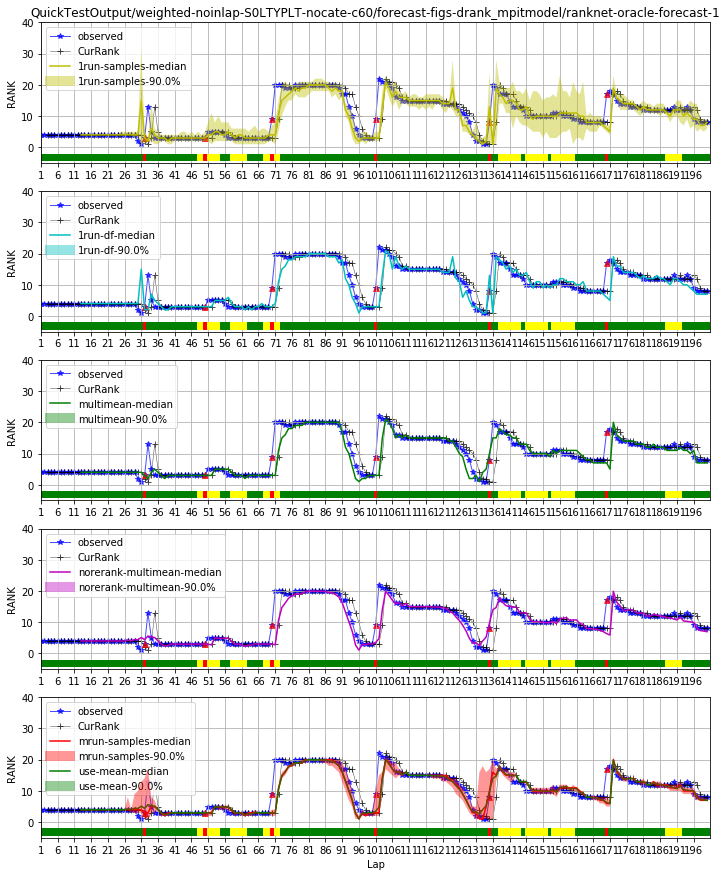

(array([ 30,  49,  93, 127, 145]),)
xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)
xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


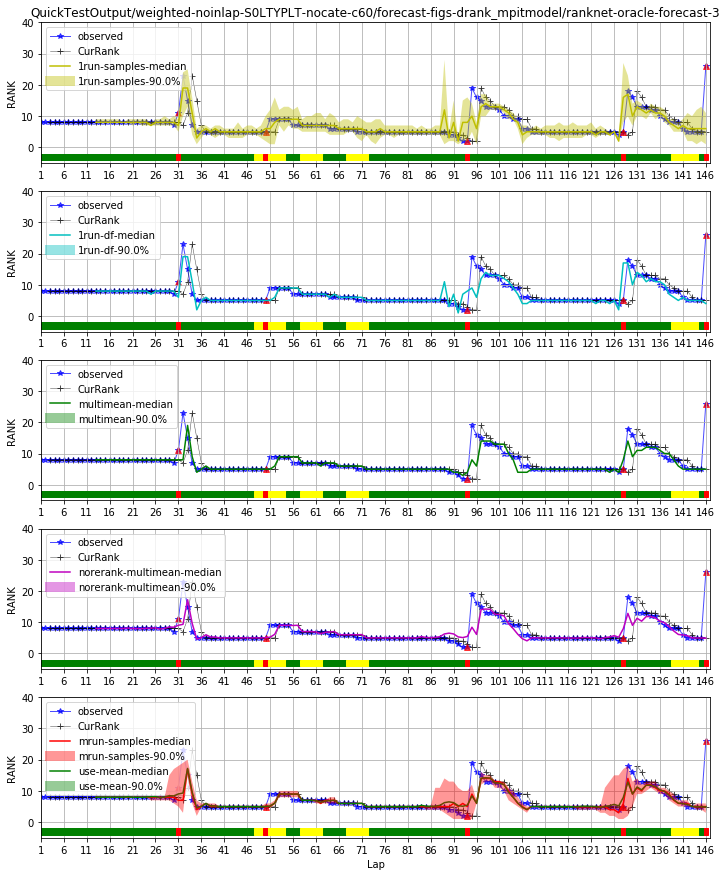

(array([ 32,  49,  92, 126, 171]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


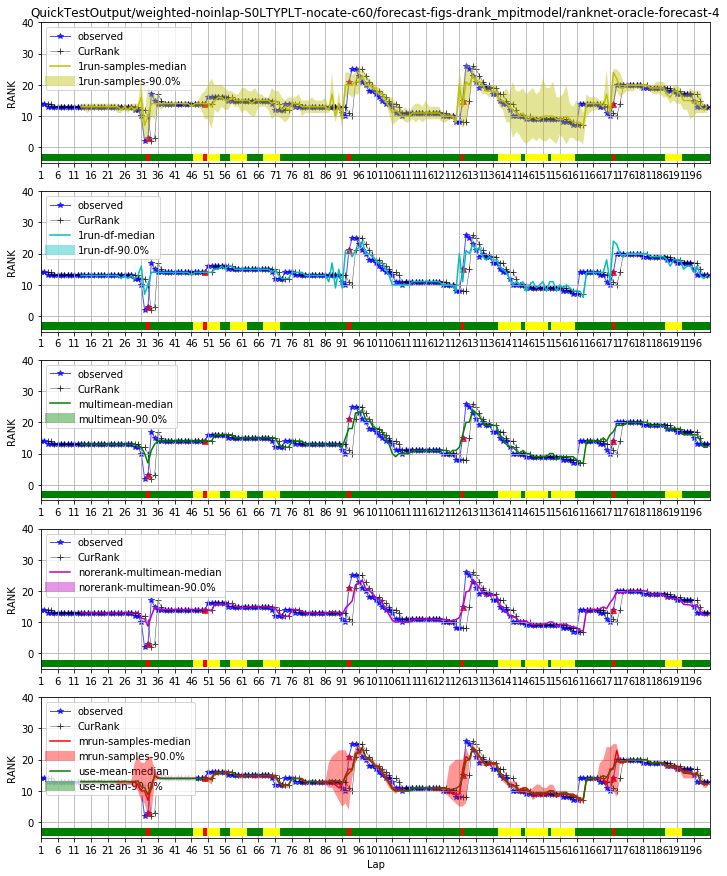

(array([ 32,  49,  69, 105, 136, 179, 190]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


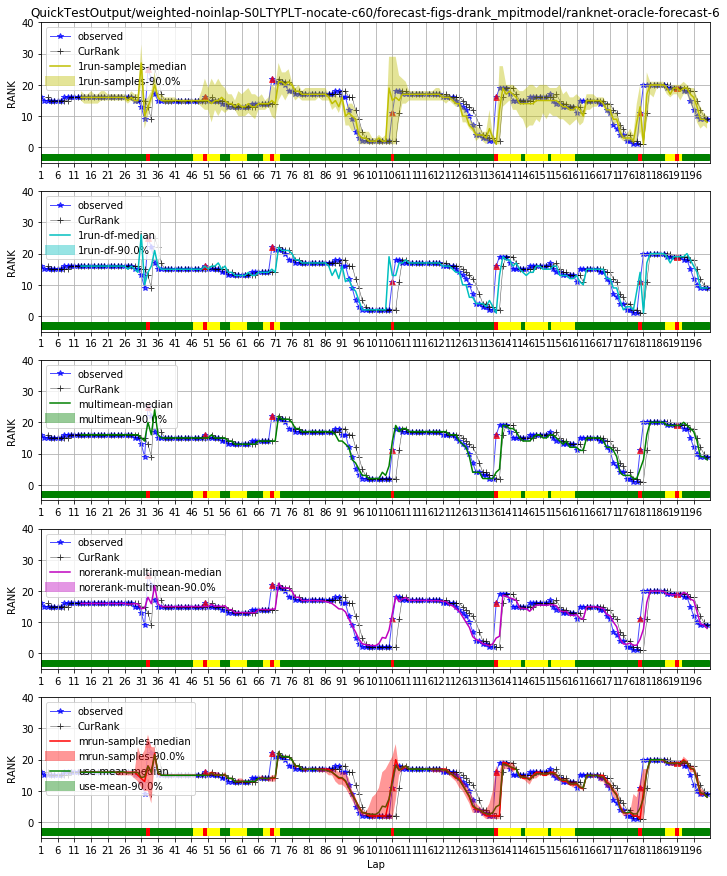

(array([ 35,  52,  59,  88,  95, 106, 119, 137, 179, 184]),)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


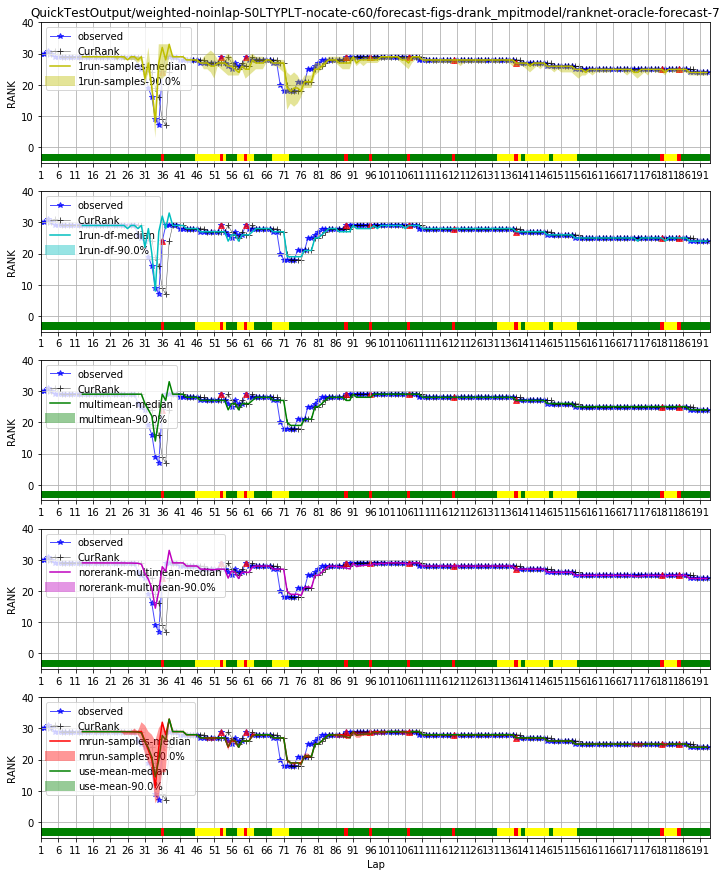

(array([ 31,  49,  94, 129, 159]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


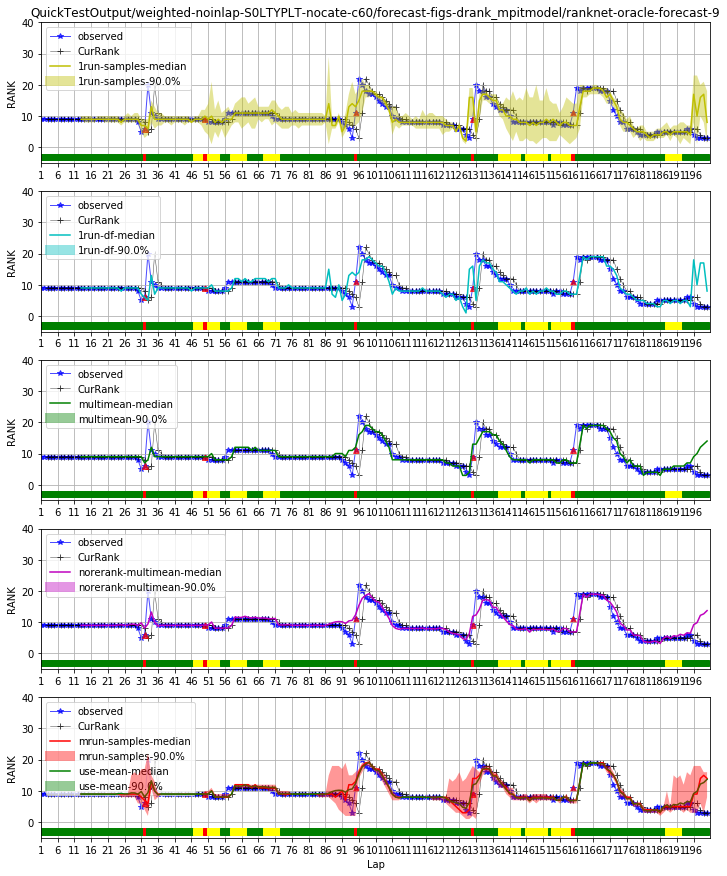

(array([33, 52]),)
xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)
xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


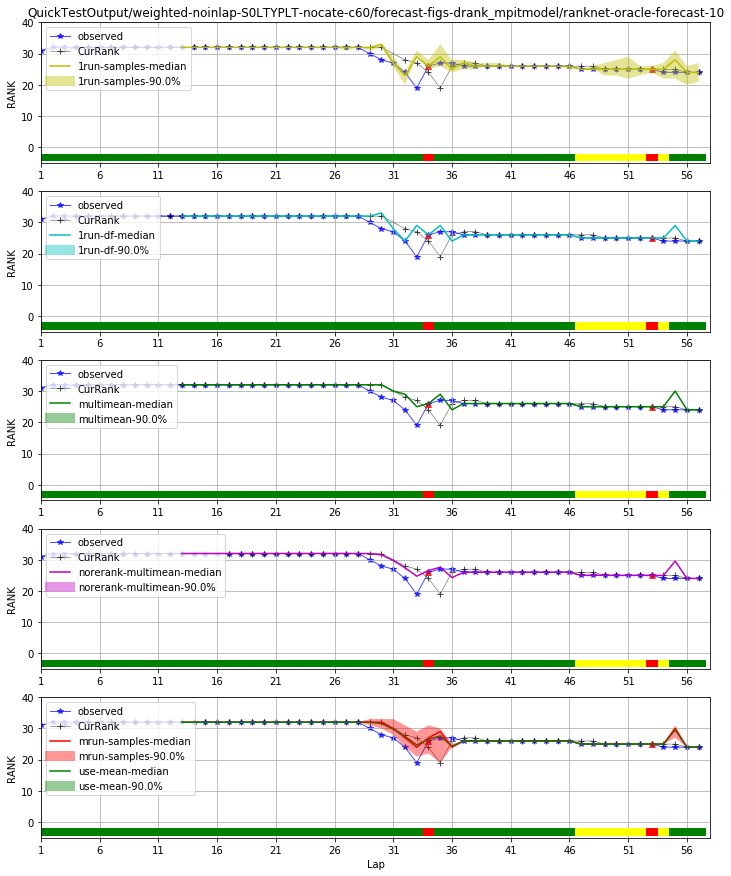

(array([ 31,  49,  93, 128, 170]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


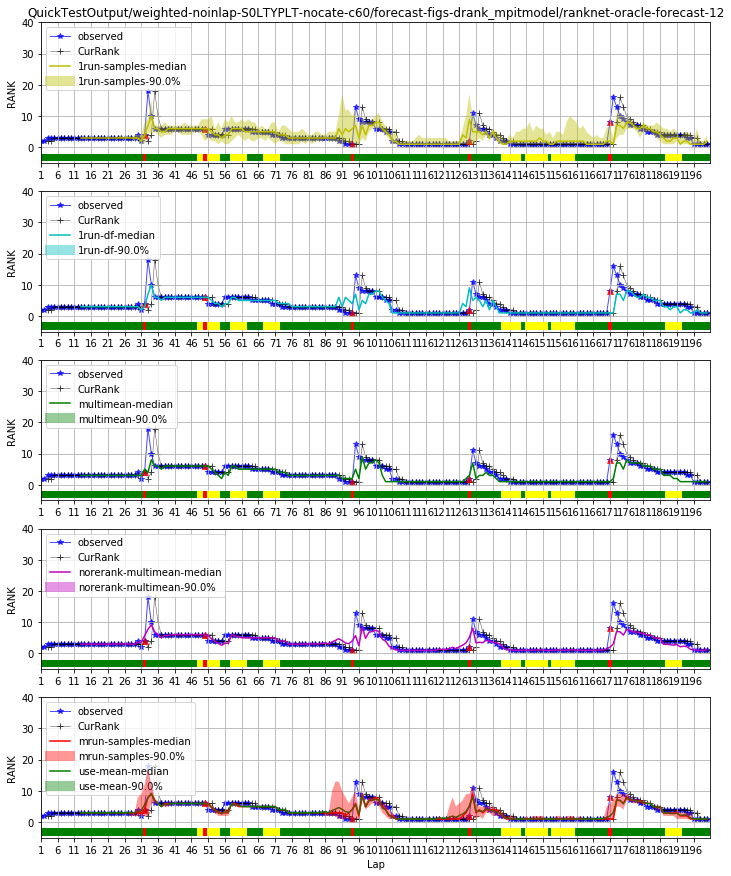

(array([28, 49]),)
xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)
xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


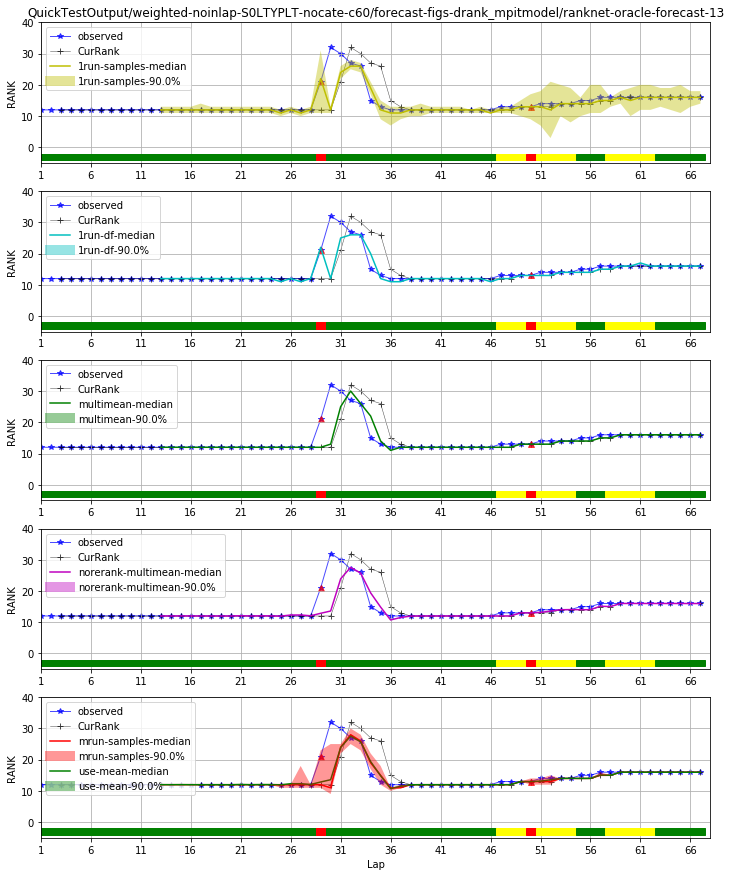

(array([ 29,  49,  89,  97, 129, 142, 171]),)
xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


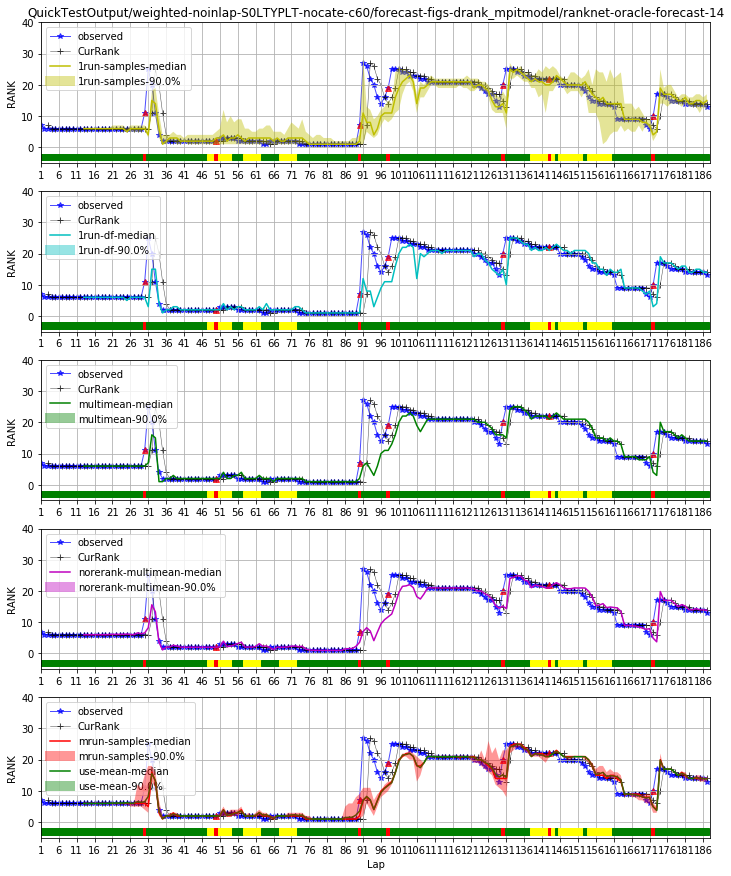

(array([ 34,  49,  69, 105, 137, 172]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


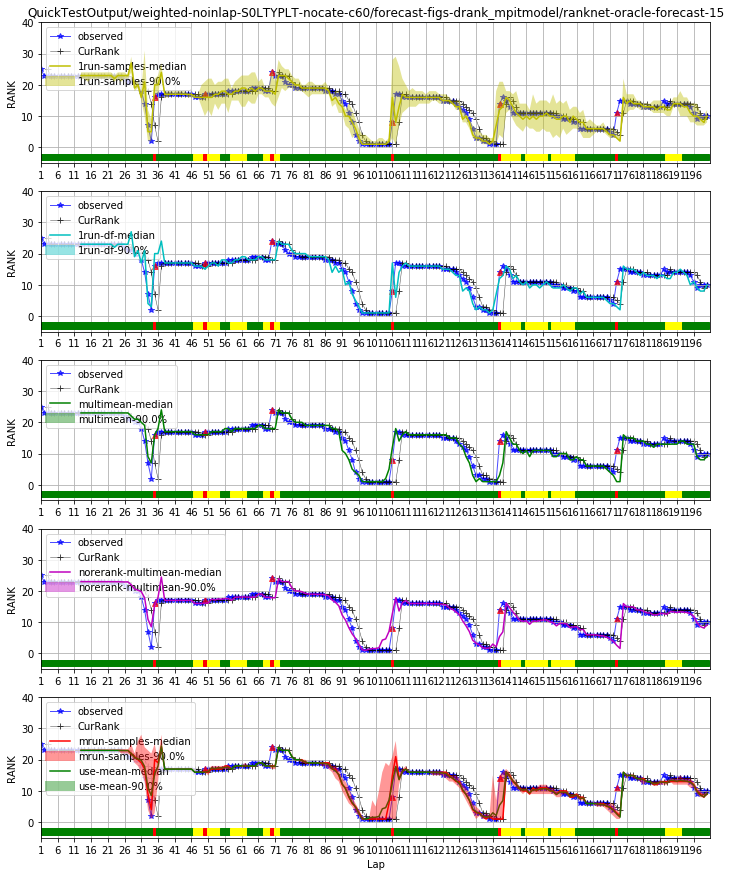

(array([ 33,  52,  69, 102, 135, 139, 141, 186, 190]),)
xlim: (25771680.0, 25771878.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771878.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771878.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771878.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


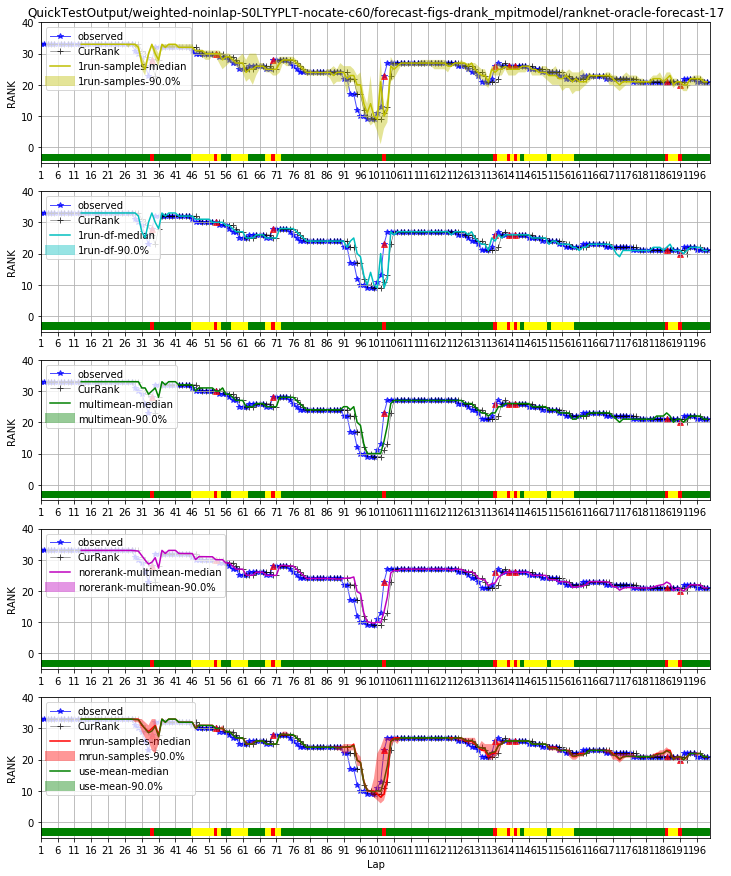

(array([ 31,  49,  96, 132]),)
xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)
xlim: (25771680.0, 25771875.0)
xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


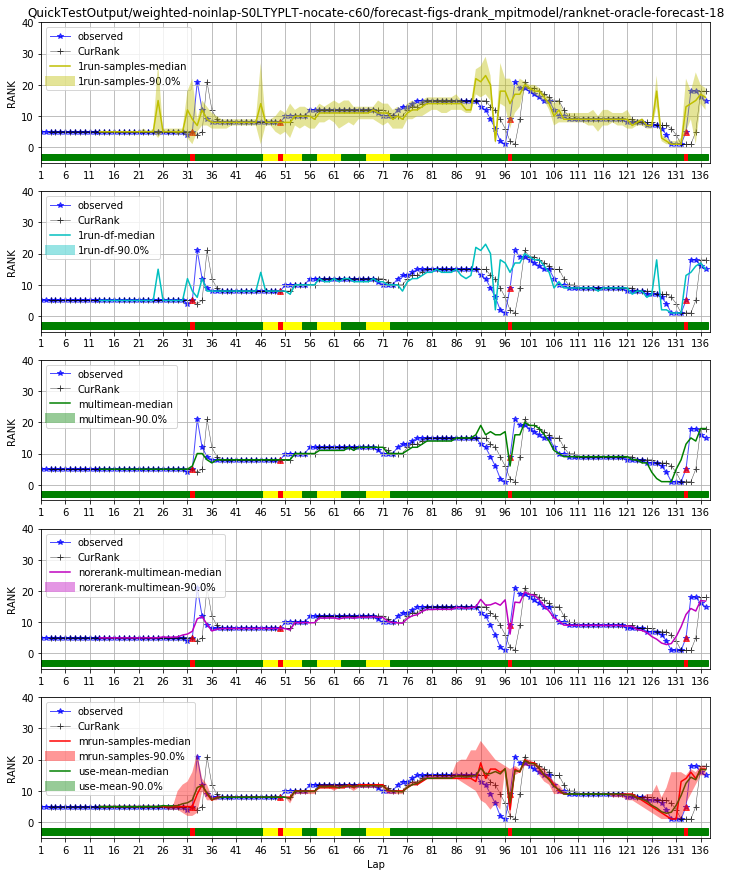

(array([ 33,  69, 107, 140, 151, 196]),)
xlim: (25771680.0, 25771878.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771878.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771878.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771878.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


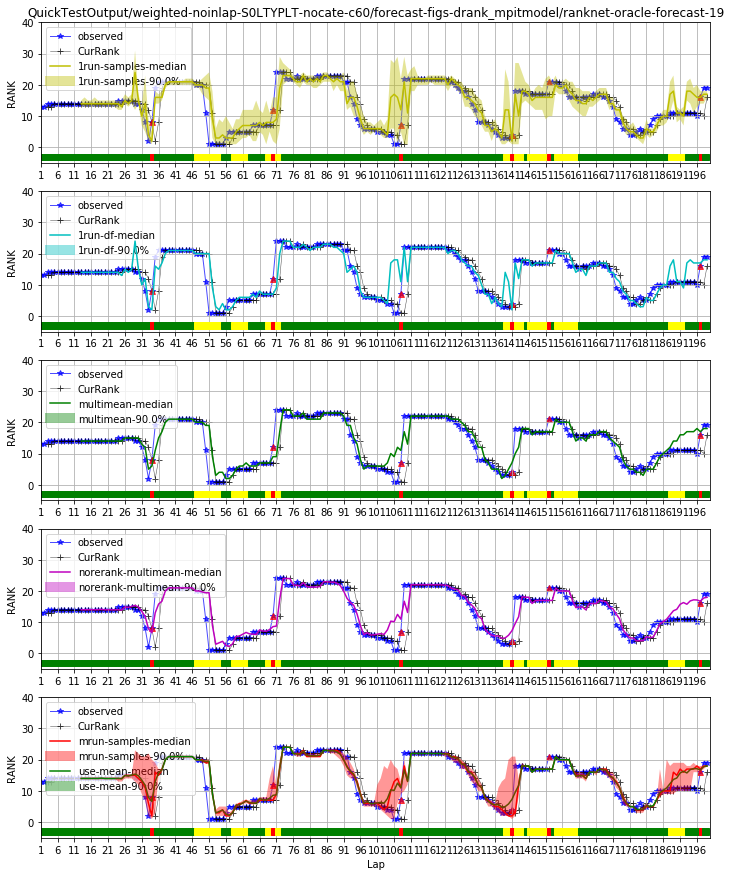

(array([ 30,  49,  91, 126, 172]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


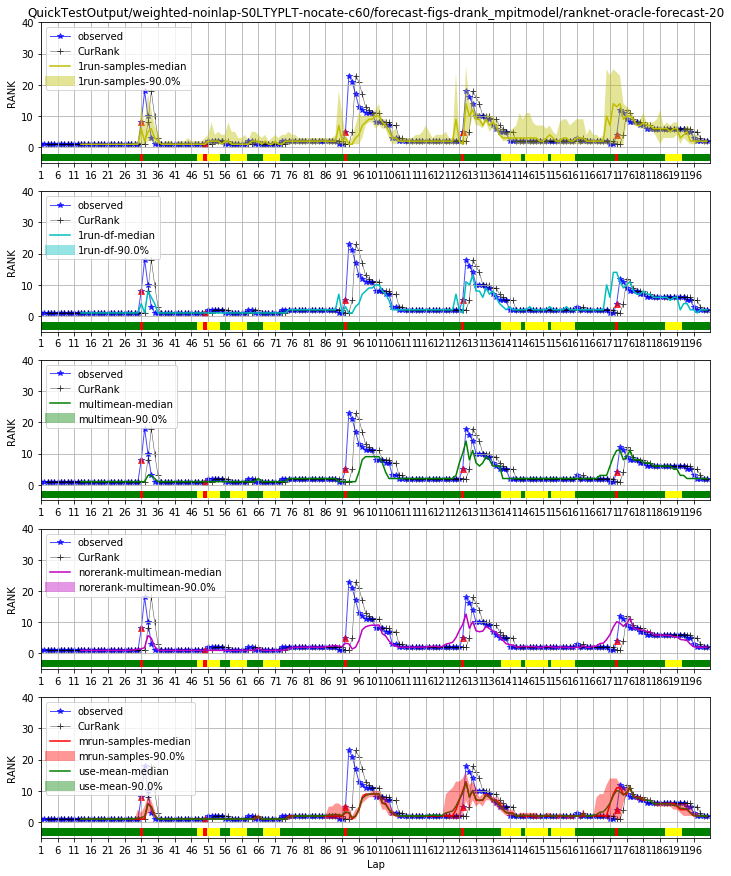

(array([ 33,  49,  93,  95, 128, 176, 189, 190]),)
xlim: (25771680.0, 25771878.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771878.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771878.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771878.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


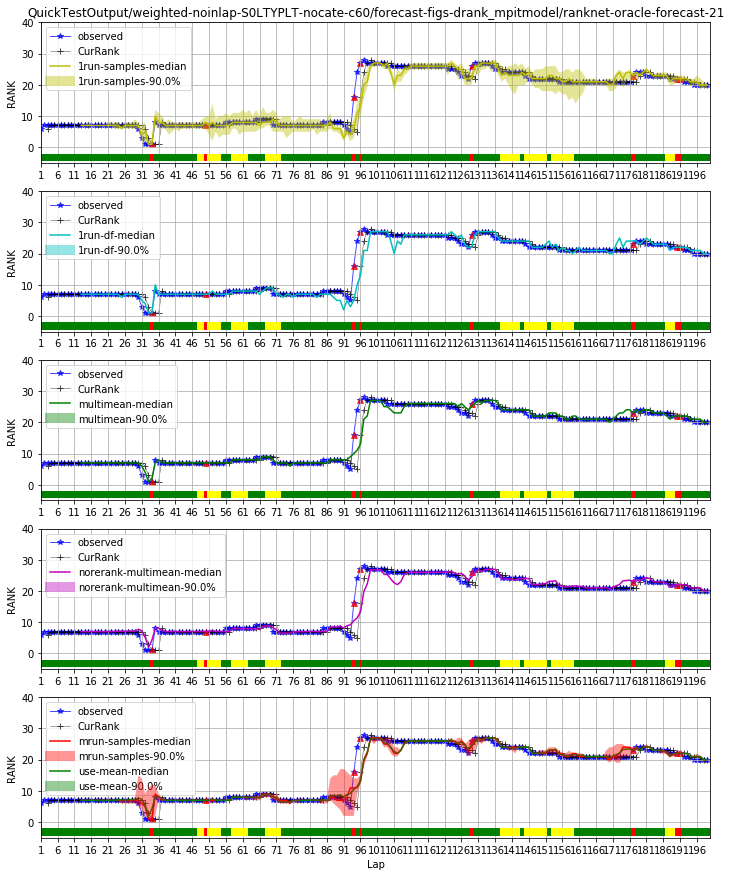

(array([ 30,  49,  92, 127, 174]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


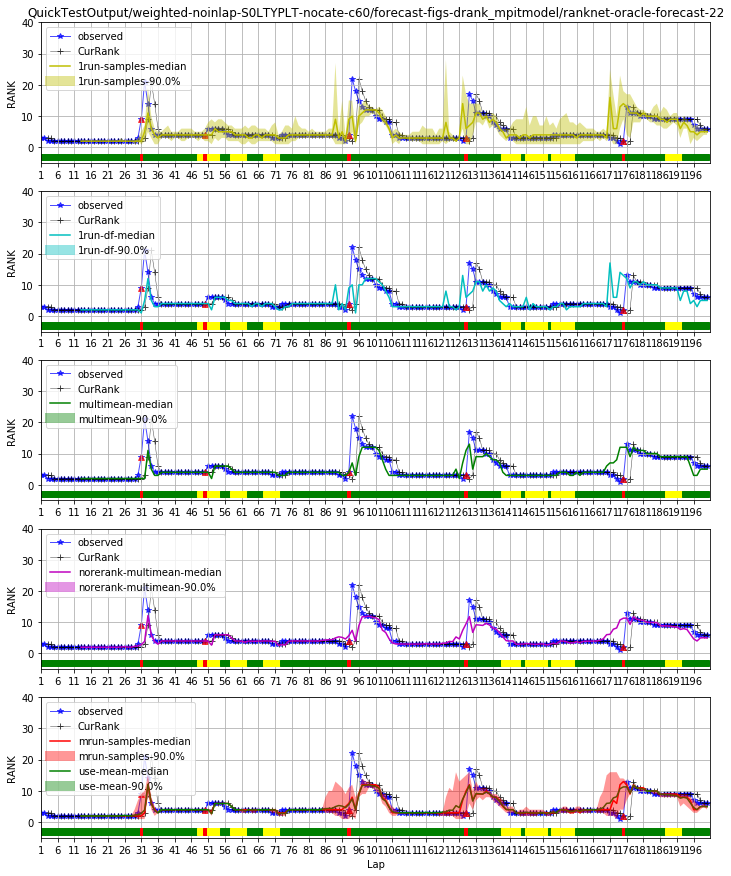

(array([ 30,  49,  90, 120, 140, 156, 159, 194]),)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


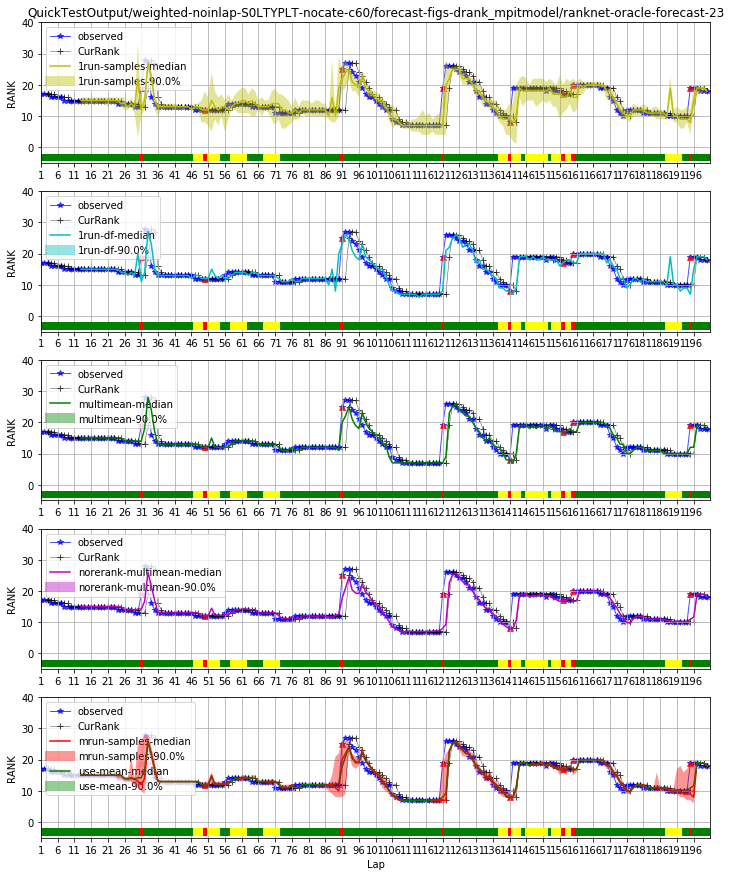

(array([ 31,  49,  92, 124]),)
xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


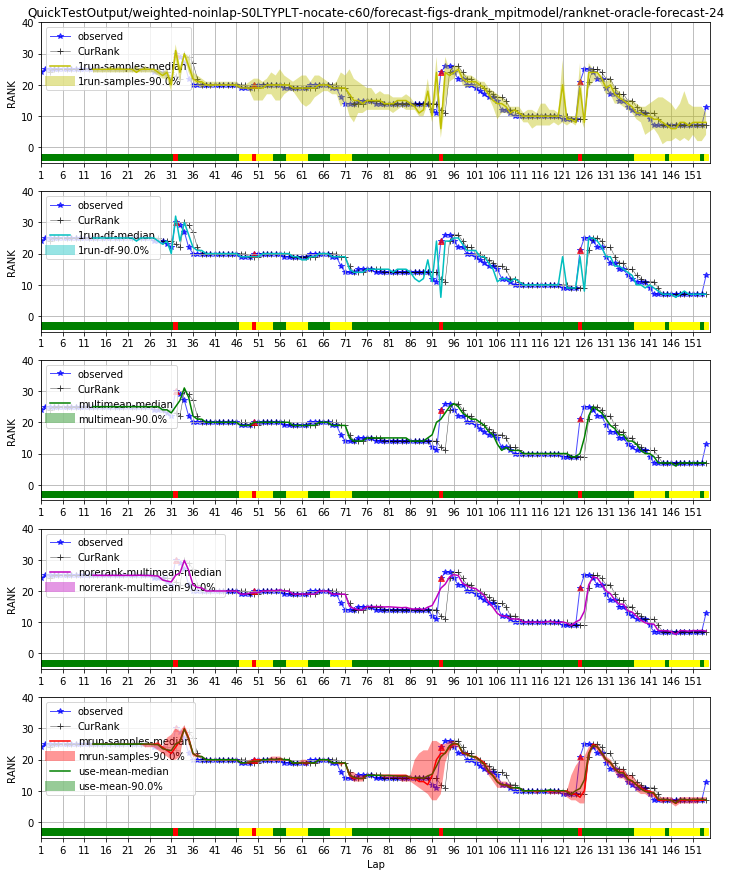

(array([ 33,  49,  69, 105, 140, 156, 195]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


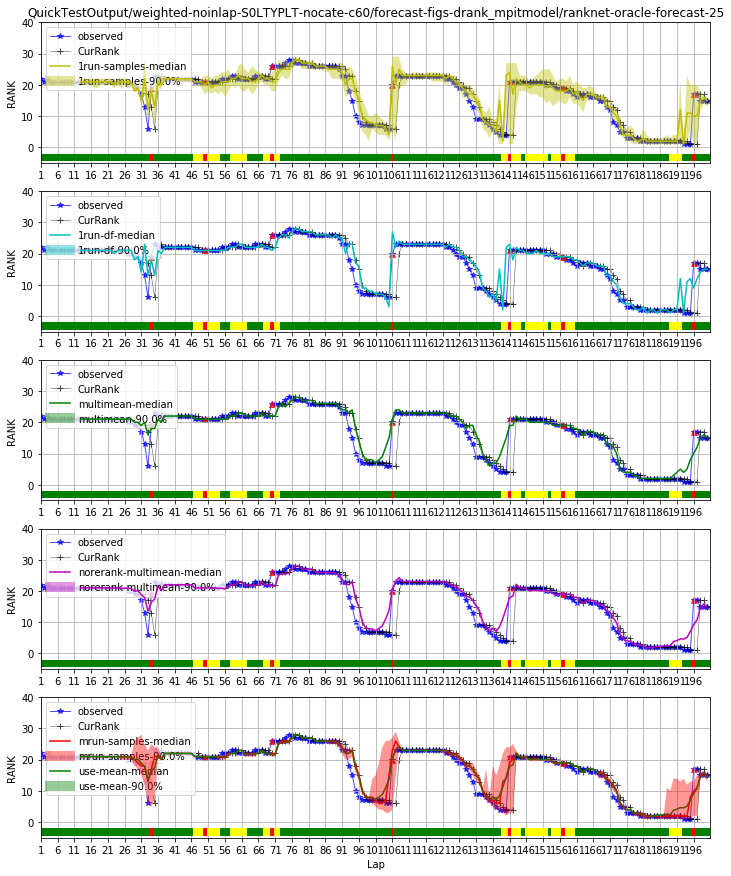

(array([ 30,  52,  53,  69, 100, 133, 149, 155, 179, 189]),)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771877.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771877.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771877.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771877.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


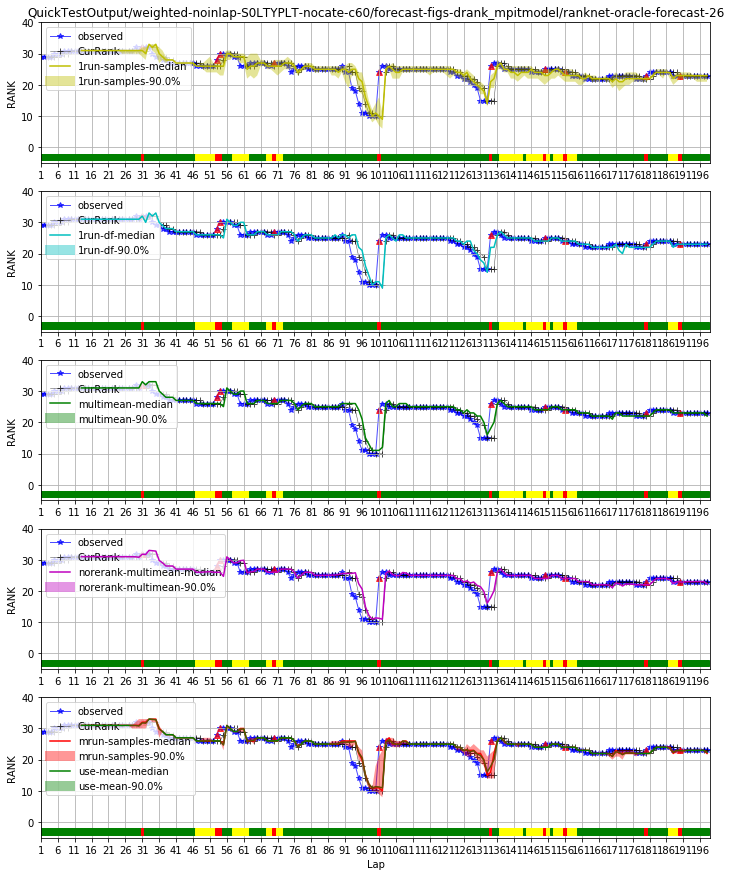

(array([ 33,  49,  94, 129, 173]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


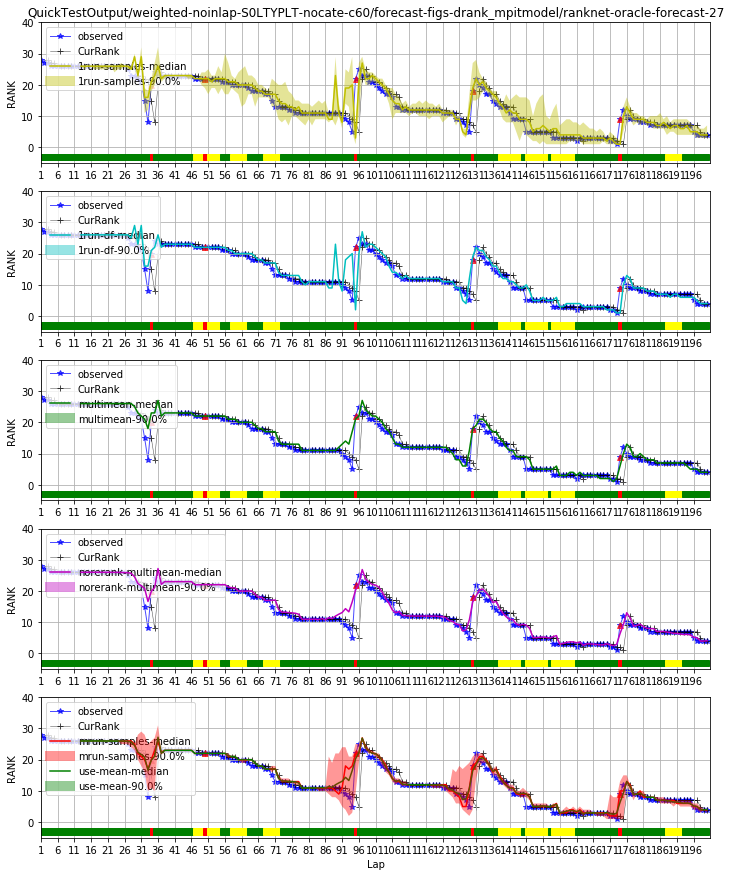

(array([ 31,  49,  93, 129, 171]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


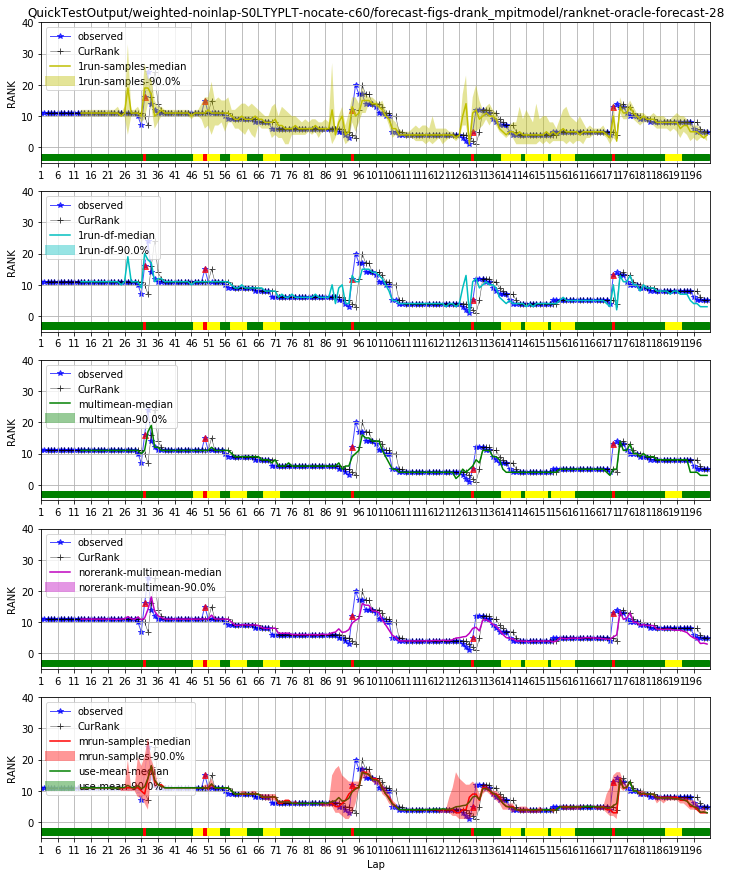

(array([ 33,  49,  69, 105, 140, 175]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


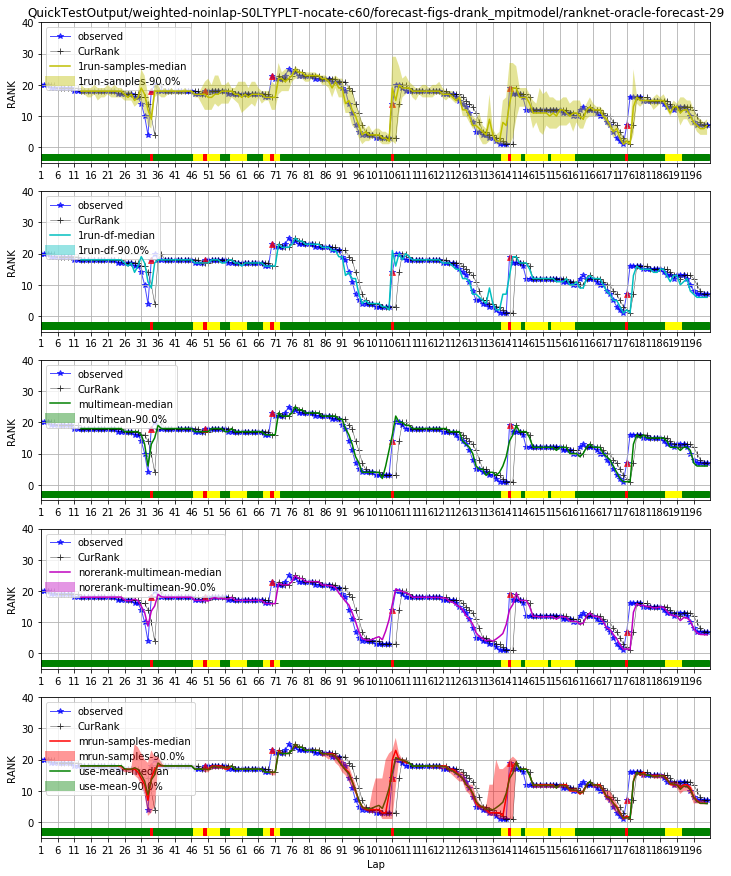

(array([32]),)
xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)
xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)


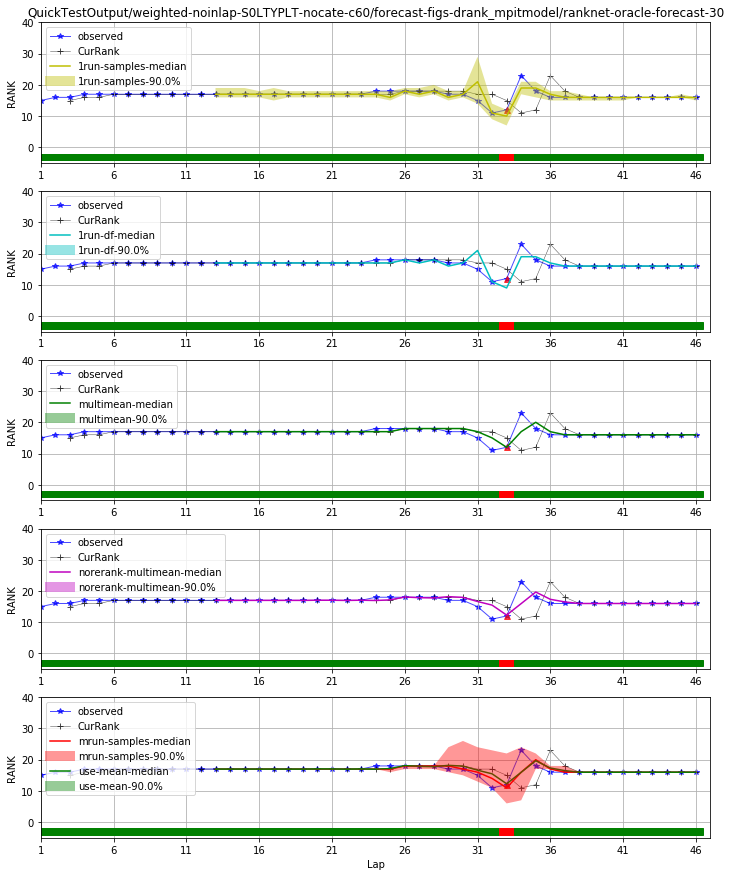

(array([ 33,  34,  51,  59,  97, 109]),)
xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)
xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


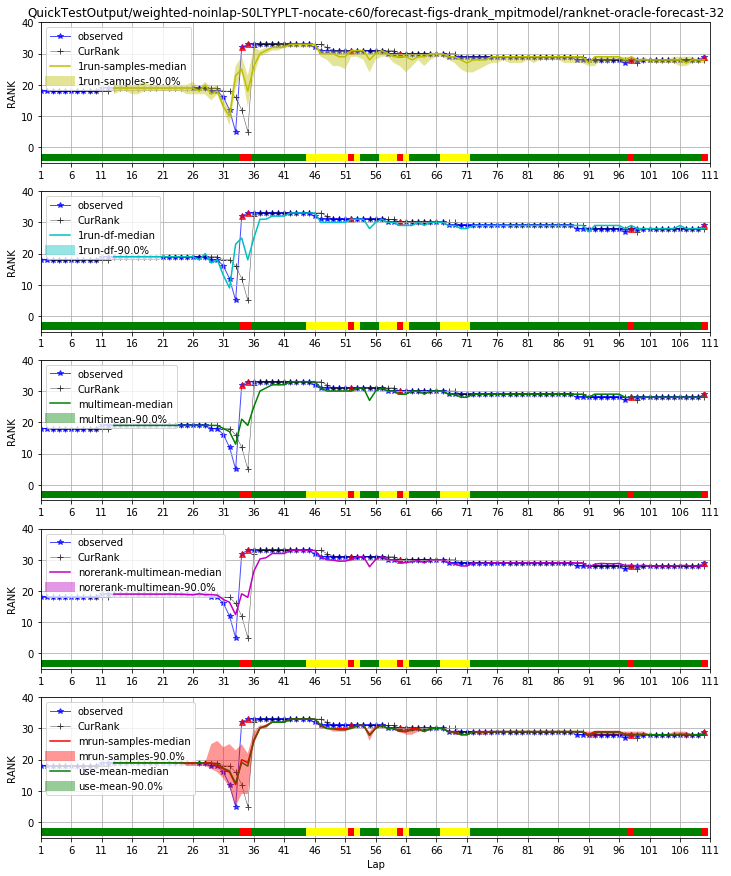

(array([30, 45]),)
xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)
xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


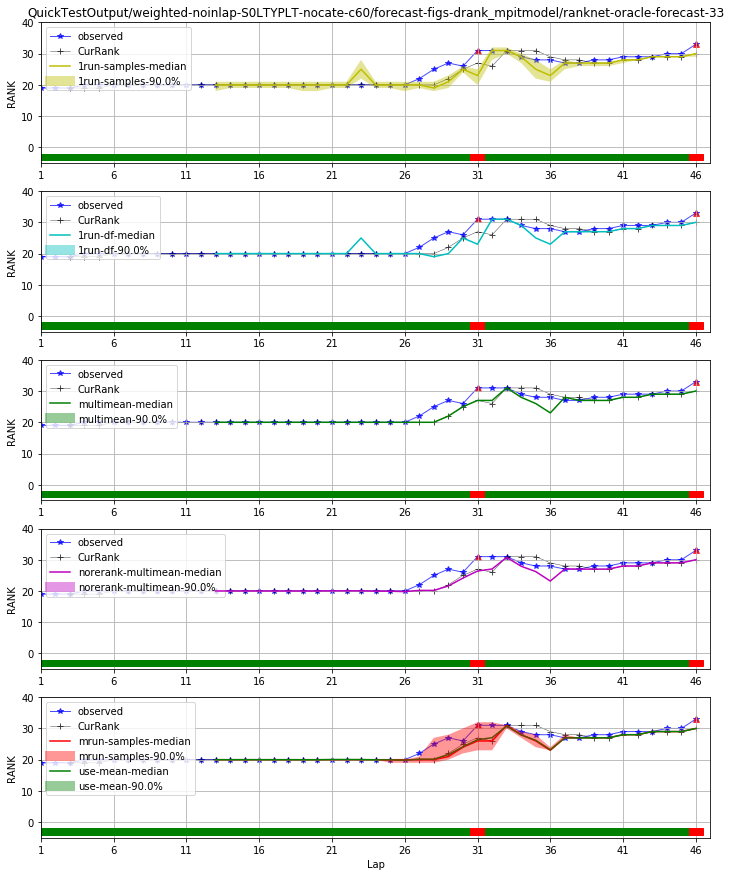

(array([ 29,  52,  59,  61,  97, 128, 155, 157, 189, 195]),)
xlim: (25771680.0, 25771877.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771877.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771877.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771877.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


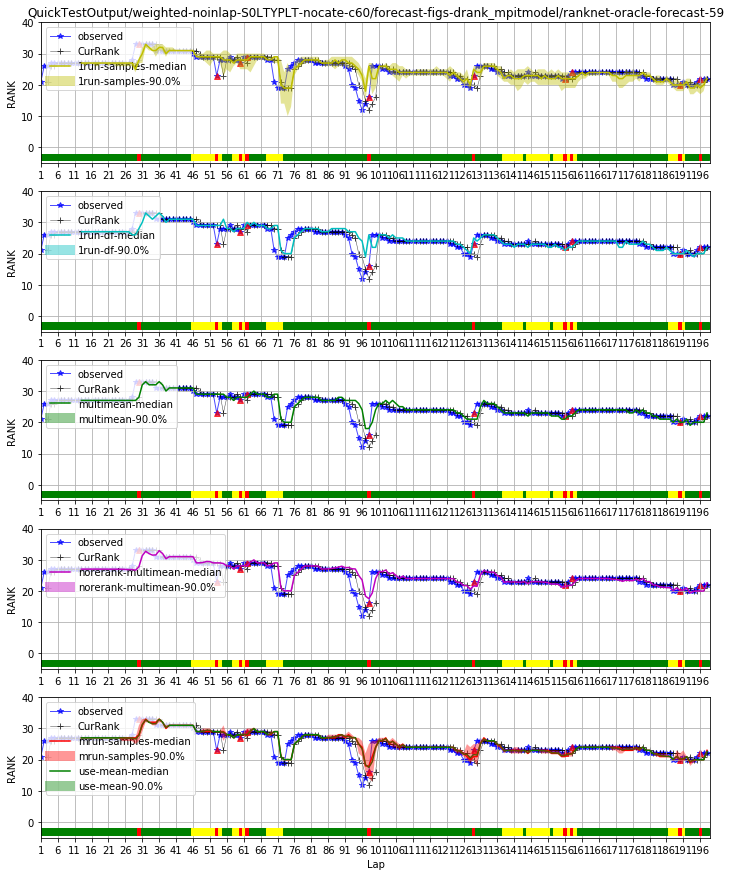

(array([ 33,  52,  95, 130, 157, 195]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


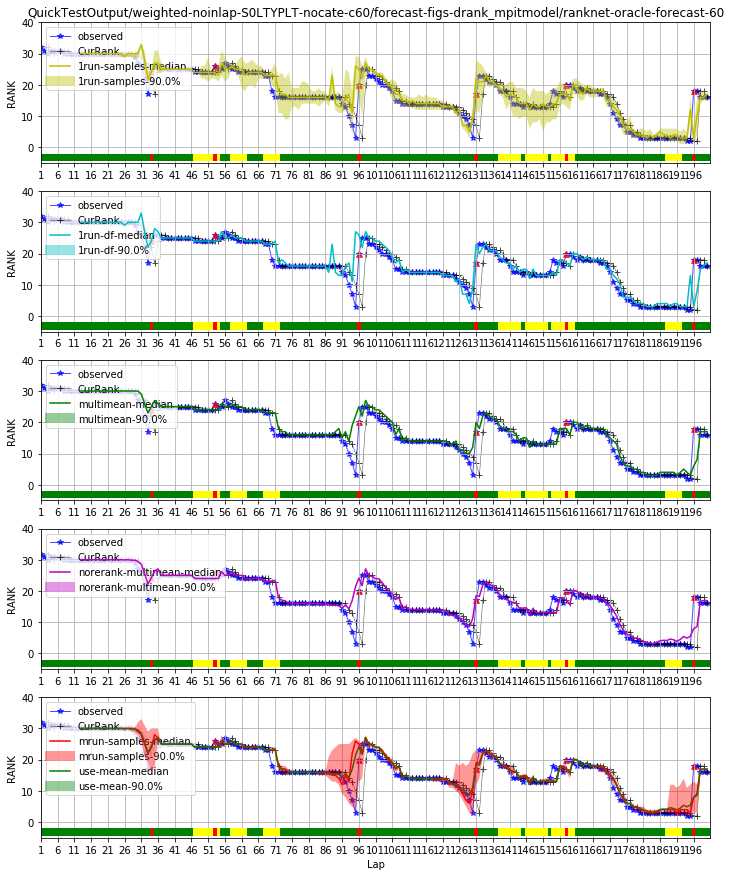

(array([ 33,  52,  95, 130, 156, 196]),)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


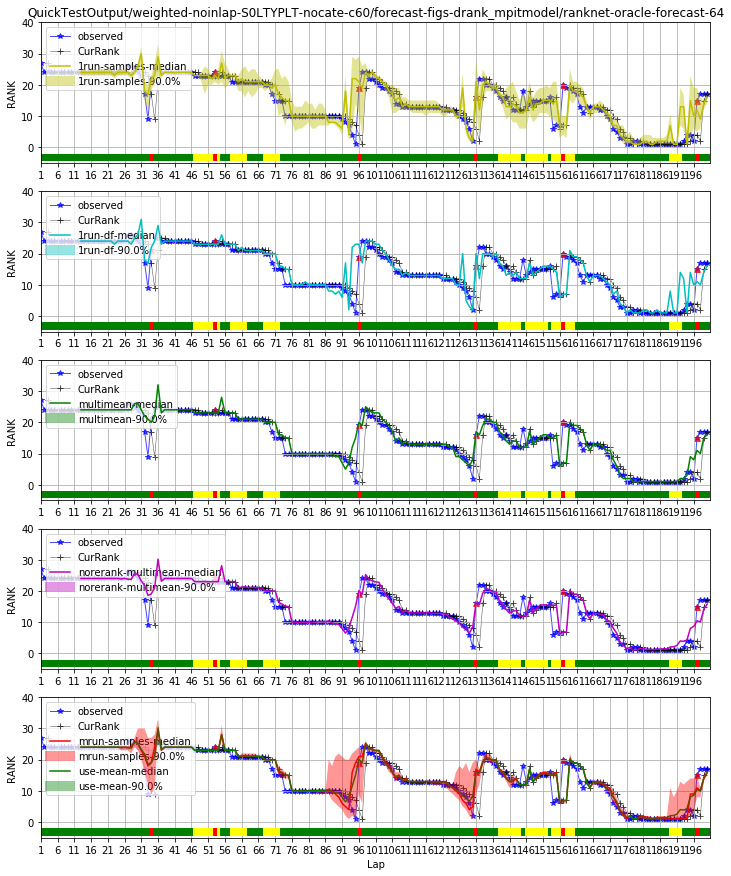

(array([ 32,  52,  69, 103, 135, 167]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


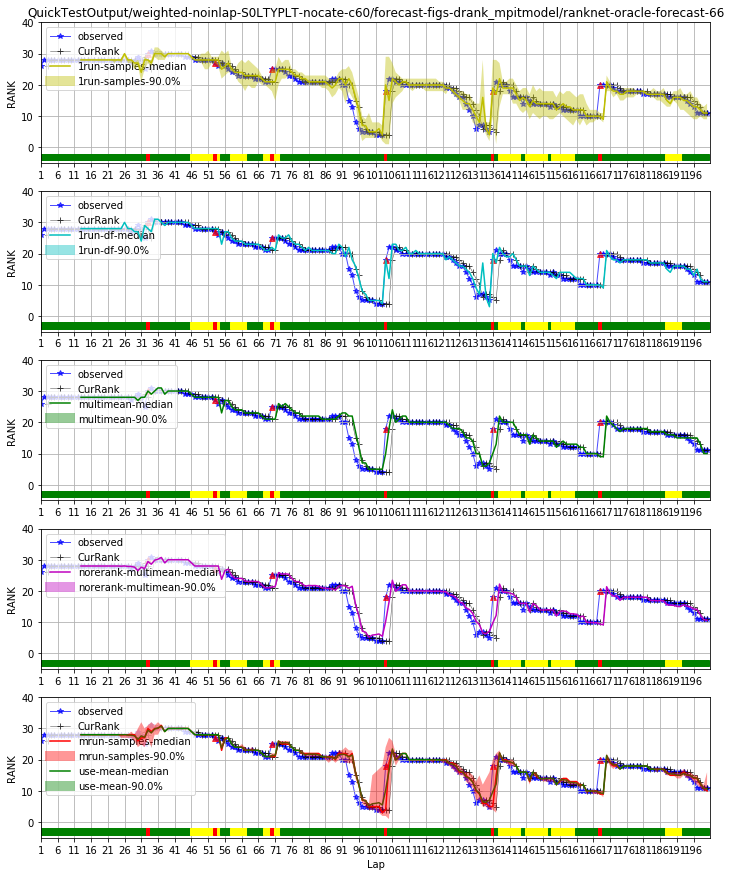

(array([ 31,  49,  59,  92, 123, 140, 170, 190]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


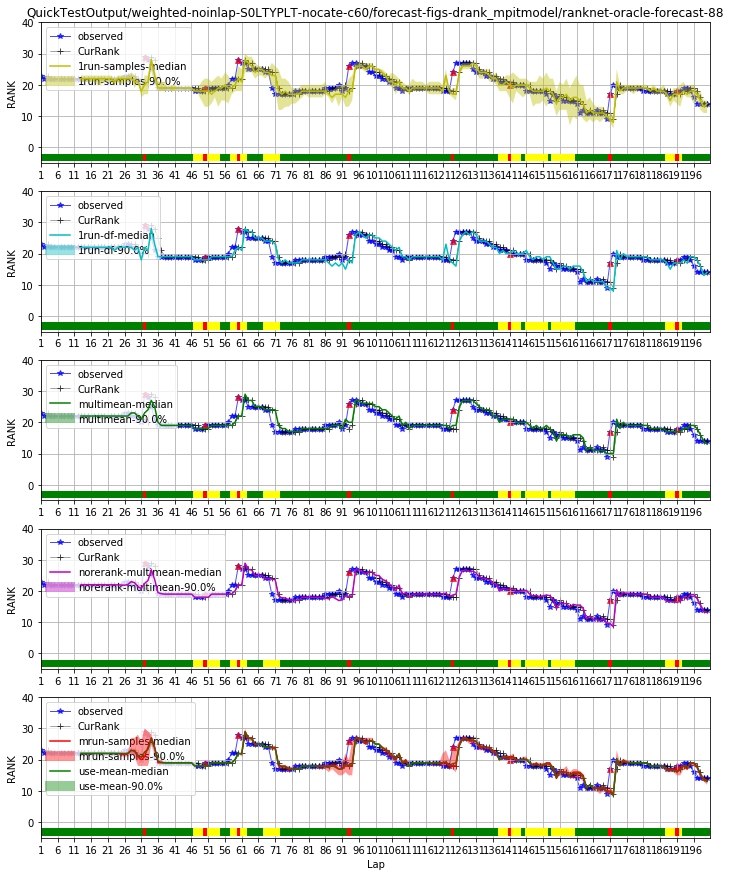

(array([ 31,  49,  91, 124, 169]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


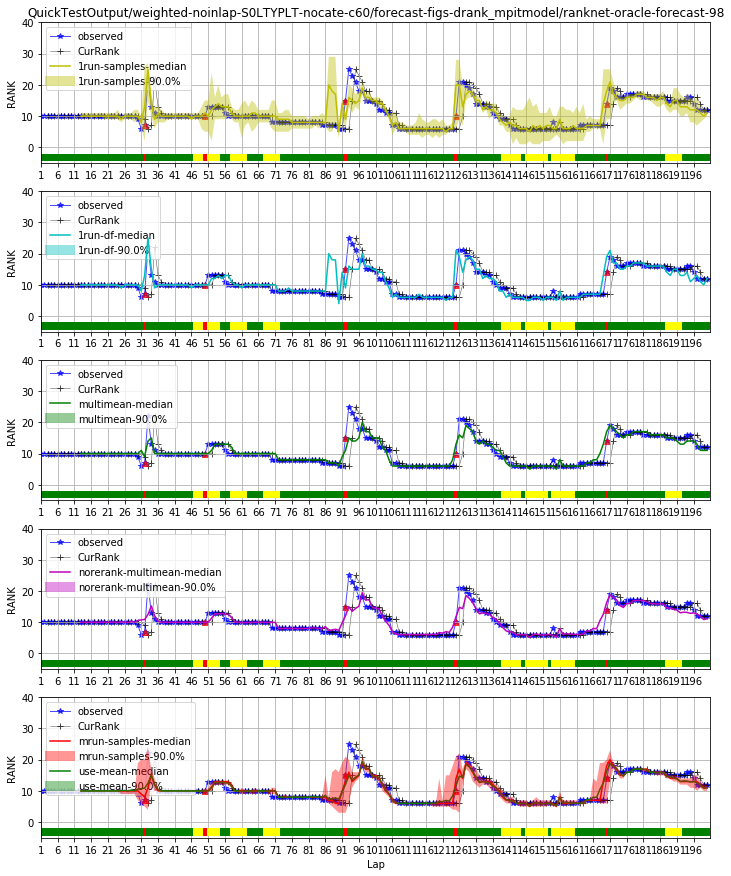

(array([ 31,  49,  69, 100, 134, 169]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


(array([ 30,  49,  93, 127, 145]),)
xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


(array([ 32,  49,  92, 126, 171]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


(array([ 32,  49,  69, 105, 136, 179, 190]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


(array([ 35,  52,  59,  88,  95, 106, 119, 137, 179, 184]),)
xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


(array([ 31,  49,  94, 129, 159]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


(array([33, 52]),)
xlim: (25771680.0, 25771875.0)
(array([ 31,  49,  93, 128, 170]),)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)
(array([28, 49]),)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)
(array([ 29,  49,  89,  97, 129, 142, 171]),)
xlim: (25771680.0, 25771875.0)
(array([ 34,  49,  69, 105, 137, 172]),)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)
(array([ 33,  52,  69, 102, 135, 139, 141, 186, 190]),)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771878.0)
(array([ 31,  49,  96, 132]),)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)
(array([ 33,  69, 107, 140, 151, 196]),)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771878.0)
(array([ 30,  49,  91, 126, 172]),)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)
(array([ 33,  49,  93,  95, 128, 176, 189, 190]),)
xlim: (25771680.0, 25771878.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


(array([ 30,  49,  92, 127, 174]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


(array([ 30,  49,  90, 120, 140, 156, 159, 194]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


(array([ 31,  49,  92, 124]),)
xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


(array([ 33,  49,  69, 105, 140, 156, 195]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


(array([ 30,  52,  53,  69, 100, 133, 149, 155, 179, 189]),)
xlim: (25771680.0, 25771877.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


(array([ 33,  49,  94, 129, 173]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


(array([ 31,  49,  93, 129, 171]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


(array([ 33,  49,  69, 105, 140, 175]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


(array([32]),)
xlim: (25771680.0, 25771875.0)
(array([ 33,  34,  51,  59,  97, 109]),)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771875.0)
(array([30, 45]),)
xlim: (25771680.0, 25771875.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


(array([ 29,  52,  59,  61,  97, 128, 155, 157, 189, 195]),)
xlim: (25771680.0, 25771877.0)
(array([ 33,  52,  95, 130, 157, 195]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


(array([ 33,  52,  95, 130, 156, 196]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


(array([ 32,  52,  69, 103, 135, 167]),)
xlim: (25771680.0, 25771879.0)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


(array([ 31,  49,  59,  92, 123, 140, 170, 190]),)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


xlim: (25771680.0, 25771879.0)
(array([ 31,  49,  91, 124, 169]),)


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:283: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


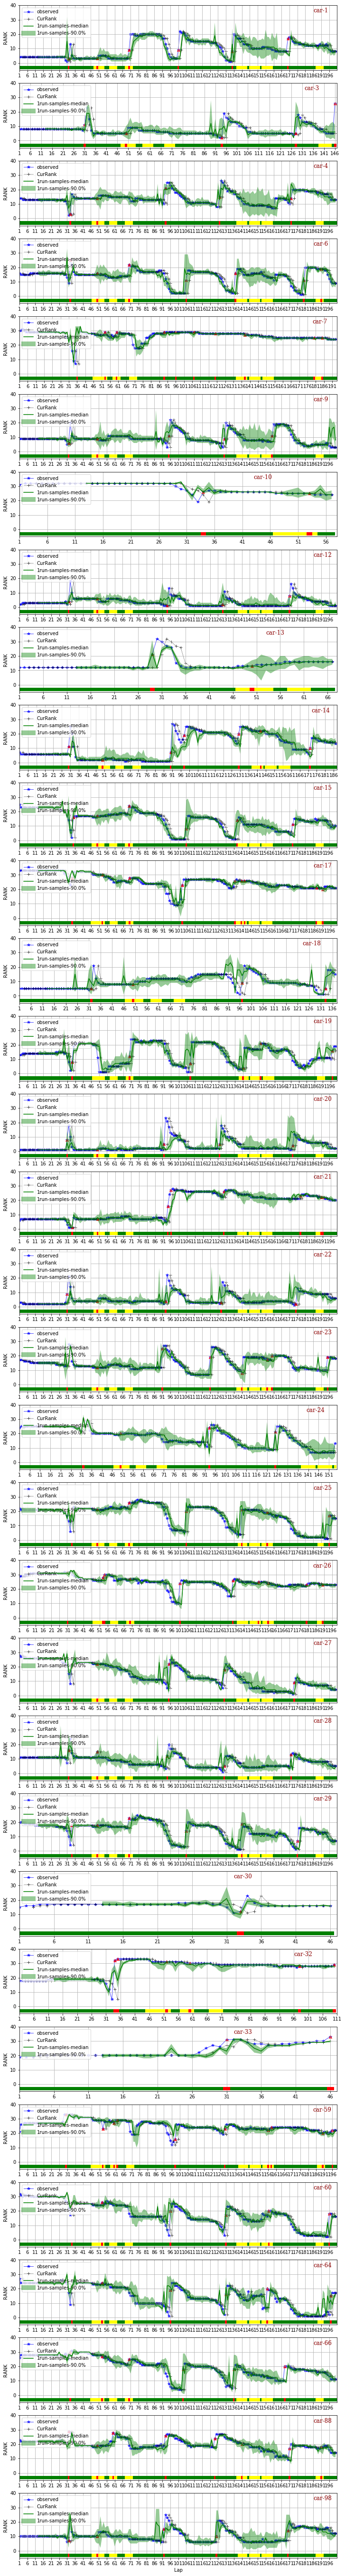

In [19]:
destdir = outputRoot + FORECAST_FIGS_DIR

if _skip_overwrite and os.path.exists(destdir):
    print('Long Forecasting Figures at:',destdir)

else:
    with open('stagedata-Indy500_2013_2019_v9_p0.pickle', 'rb') as f:
        stagedata = pickle.load(f, encoding='latin1') 
        _alldata, rankdata, _acldata, _flagdata = stagedata['Indy500-2018']

    #destdir = outputRoot + 'oracle-forecast-figs/'
    os.makedirs(destdir, exist_ok=True)
        
    for carno in alldata:
        plotoracle(alldata, carno, destdir)
        
    #draw summary result
    outputfile = destdir + f'{configname}'
    plotallcars(alldata, outputfile, drawid = 0)

In [20]:
#plotoracle(alldata, 3)    

In [21]:
outputRoot

'QuickTestOutput/weighted-noinlap-S0LTYPLT-nocate-c60/'

In [22]:
oracle_eval_result

Year     Model                                              ExpID laptype  \
0  2018  pitmodel  weighted-noinlap-S0LTYPLT-nocate-c60-drank-pit...     all   
1  2018  pitmodel  weighted-noinlap-S0LTYPLT-nocate-c60-drank-pit...  normal   
2  2018  pitmodel  weighted-noinlap-S0LTYPLT-nocate-c60-drank-pit...     pit   

    SignAcc       MAE   50-Risk   90-Risk  
0  0.765957  1.088390  0.084134  0.062583  
1  0.924242  0.345996  0.031547  0.025707  
2  0.680328  1.514741  0.116352  0.085176

In [23]:
loopcnt=2